In [1]:
import os
import sys

# Add the src directory to the sys path to allow absolute imports
sys.path.append(os.path.join(os.path.dirname(__file__), 'src'))

# PyTorch imports
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import _LRScheduler

# Pytorch Geometric imports
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, OnDiskDataset, download_url, extract_zip
from torch_geometric.data.data import BaseData, Data
from src.modifications.torch_geometric_modified import from_smiles

# Project specific imports
from src.models.AttentiveFP_v2 import AttentiveFP
from src.utils.data_utils import DatasetAttentiveFP, GenSplit
from src.utils.plot_utils import make_subplot, make_density_plot, make_subplot_v2
from src.loss.spectral_loss import get_spectral_fn, normalize_spectra
from src.filters.savitzky_golay_torch import initialize_savgol_filter
import src.config.params as params
from src.utils.sweep_utils import find_batch_size
from src.utils.wandb_utils import log_to_wandb
from src.utils.scheduler_utils import build_lr_scheduler
# Other imports
import yaml
import wandb
import argparse
from tqdm import tqdm
import pandas as pd
import numpy as np
import time
import random
import logging


# Check for config_spectra.yml
config_path = os.path.join(os.path.dirname(__file__), 'src', 'config', 'config_spectra.yml')
if not os.path.exists(config_path):
    raise FileNotFoundError("config_spectra.yml not found in the config directory")
with open(config_path) as file:
    config_spectra = yaml.load(file, Loader=yaml.FullLoader)


In [2]:
# Make all wavelengths integers, some are strings like '150_pred'
def make_int(x):
    try:
        return int(x)
    except:
        return int(x[:-5])


#Smiles column to string
def make_string(x):
    return str(x)

In [4]:
WORKSPACE_PATH = params.WORKSPACE_PATH
PERSISTENT_STORAGE_PATH = params.PERSISTENT_STORAGE_PATH

In [5]:
# Load the dataset
path_tmp = os.path.join(PERSISTENT_STORAGE_PATH, default_config['DATA_DIRECTORY'], 'test', 'data')
dataset = DatasetAttentiveFP(root=path_tmp, split='test', one_hot=config_spectra['one_hot'], config=config_spectra)

#Dataloader
val_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=default_config['num_workers'], drop_last=True)

Split file already exists. Skipping...


In [6]:
checkpoint_ids = ['d796nu6p', 'nio6rm1h', 'dvtqvqpb', 'fbltmaax', '6i21o4uv', 'yzdzzjyo', 'ea7beqo7', 'efj1ucgj', 'hiheinzh']
checkpoints_dirs = '/home/nyrenw/Documents/Thesis/Attentive_fp/models/ensemble'

In [7]:
df = {'smiles': [], 'spectra': [], 'spectra_pred': [], 'checkpoint': []}

In [8]:
for checkpoint_id in checkpoint_ids:
    checkpoint_path_attentive_fp = os.path.join(checkpoints_dirs, f'checkpoint_{checkpoint_id}.pt')
    checkpoint_settings_path = 'models/ensemble/checkpoint_ensemble.yml'


    #Load AttentiveFP model
    checkpoint = torch.load(checkpoint_path_attentive_fp)
    #Load model settings
    with open(checkpoint_settings_path, 'r') as f:
        model_settings = yaml.load(f, Loader=yaml.FullLoader)

    # Overrite default_config with model settings if keys match
    for key in default_config:
        if key in model_settings['parameters']:
            value = list(model_settings['parameters'][key].values())[0]
            # value = model_settings['parameters'][key][list(subkey)[0]]
            # if value is a list, then the length is 1, so we take the first element
            if isinstance(value, list):
                default_config[key] = value[0]
            else:
                default_config[key] = value


    """    model = AttentiveFP(
            in_channels=26,
            hidden_channels=config["hidden_channels"],
            out_channels=config["out_dim"], 
            edge_dim=14,
            num_layers=config["num_layers"],
            num_timesteps=config["num_timesteps"],
            dropout=config["dropout"],
            attention_mode=config['Attention_mode'],
            heads=config['heads']
        )"""
    model = AttentiveFP(in_channels=26,
                        hidden_channels=default_config["hidden_channels"],
                        out_channels=50,
                        edge_dim=14,
                        num_layers=default_config["num_layers"],
                        num_timesteps=default_config["num_timesteps"],
                        dropout=default_config["dropout"],
                        attention_mode=default_config['Attention_mode'],
                        heads=default_config['heads']
                        )
    # Load checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    # Load model to device
    model.to('cuda')
    model.eval()

    # Eval model and store predictions in a pd dataframe
    for i, data in enumerate(val_loader):
        data = data.to('cuda')
        with torch.no_grad():
            pred, middle_states = model(data.x, data.edge_index, data.edge_attr, data.batch)
            pred = torch.pow(pred, 2)
            pred = pred/torch.max(pred, dim=1, keepdim=True)[0]
            target_spectra = data.y
            target_spectra = target_spectra/torch.max(target_spectra, dim=1, keepdim=True)[0]
            pred, target_spectra, _ = normalize_spectra(pred, target_spectra, torch_device=data.x.device)
        df['smiles'].extend(data.smiles)
        df['spectra'].extend(target_spectra.cpu().numpy())
        df['spectra_pred'].extend(pred.cpu().numpy())
        df['checkpoint'].extend([checkpoint_id]*len(data.smiles))
        #if i == 100:
        #    break

df = pd.DataFrame(df)


In [9]:
# shape of df
print(df.shape)

(4753773, 4)


In [10]:

# Save only equal smiles between df and df_tidy_chemprop_test
df = df[df['smiles'].isin(df_tidy_chemprop_test['smiles'])]


In [11]:
print(df.shape)

(944317, 4)


In [12]:
df_tidy_chemprop_test = df_tidy_chemprop_test[df_tidy_chemprop_test['smiles'].isin(df['smiles'])]

In [13]:
#shape of df
print(df.shape)
display(df.head(5))


(944317, 4)


smiles  \
7                C=CCOCC(Cc1ccccc1)CN(Nc1ncccn1)C1CC1   
15  CC(C)N1CCCc2cc(C=CC(=O)NNc3ccnc(Oc4ccccc4)c3)c...   
19      N#Cc1ccc(CCS(=O)(=O)CCSc2nc(-c3ccccc3)cs2)cc1   
21             CC1CC(C(=CO)NCCCNC(=O)c2cccc3nsnc23)C1   
22                      Cc1occc1CN(C)C(C)CCc1nc[nH]n1   

                                              spectra  \
7   [1.4594023e-09, 1.4594023e-09, 1.4594023e-09, ...   
15  [1.038728e-09, 1.038728e-09, 1.038728e-09, 1.0...   
19  [1.2162217e-09, 1.2162217e-09, 1.2162217e-09, ...   
21  [9.629018e-10, 9.629018e-10, 9.629018e-10, 9.6...   
22  [0.102101766, 0.1797011, 0.21555223, 0.1761403...   

                                         spectra_pred checkpoint  
7   [0.01683887, 0.023834731, 0.043083396, 0.03865...   d796nu6p  
15  [0.01160342, 0.016414538, 0.026617864, 0.04309...   d796nu6p  
19  [0.003854229, 0.0050181523, 0.007778559, 0.016...   d796nu6p  
21  [0.017744673, 0.023546794, 0.03702003, 0.05323...   d796nu6p  
22  [0.027798347, 0.045423664, 0.085423954, 0.0999...   d796nu6p

In [14]:
# Sort by smiles and checkpoint
df = df.sort_values(by=['smiles', 'checkpoint'])

In [15]:
# Tidy df such that spectra arrays are in columns from 150 to 450 with 6 nm steps
df_tidy = pd.DataFrame()
# Copy of df but only with smiles and checkpoint
df_tidy = df[['smiles', 'checkpoint']]
for i, val in enumerate(range(150, 450, 6)):
    df_tidy[str(val)] = [x[i] for x in df['spectra']]
    df_tidy[str(val) + '_pred'] = [x[i] for x in df['spectra_pred']]
display(df_tidy.head(5))

smiles checkpoint       150  150_pred       156  156_pred  \
2437668  C#CC#CC#CC1CO1   6i21o4uv  0.010127  0.027609  0.012323  0.044209   
430139   C#CC#CC#CC1CO1   d796nu6p  0.010127  0.006675  0.012323  0.009437   
1164993  C#CC#CC#CC1CO1   dvtqvqpb  0.010127  0.003055  0.012323  0.004195   
3176946  C#CC#CC#CC1CO1   ea7beqo7  0.010127  0.017373  0.012323  0.017878   
3885744  C#CC#CC#CC1CO1   efj1ucgj  0.010127  0.012854  0.012323  0.022381   

              162  162_pred       168  168_pred  ...           420  \
2437668  0.016312  0.033344  0.019144  0.030001  ...  1.674872e-09   
430139   0.016312  0.016095  0.019144  0.023011  ...  1.674872e-09   
1164993  0.016312  0.010436  0.019144  0.021417  ...  1.674872e-09   
3176946  0.016312  0.020554  0.019144  0.026095  ...  1.674872e-09   
3885744  0.016312  0.032872  0.019144  0.040566  ...  1.674872e-09   

             420_pred           426      426_pred           432      432_pred  \
2437668  7.669767e-07  1.674872e-09  2.379935e-05  1.674872e-09  1.114423e-05   
430139   4.009958e-05  1.674872e-09  1.462599e-04  1.674872e-09  9.776215e-05   
1164993  2.263830e-04  1.674872e-09  9.850692e-05  1.674872e-09  7.902372e-05   
3176946  1.056675e-06  1.674872e-09  7.160504e-07  1.674872e-09  2.428545e-08   
3885744  2.776166e-06  1.674872e-09  2.080344e-06  1.674872e-09  4.908035e-07   

                  438      438_pred           444      444_pred  
2437668  1.674872e-09  1.018949e-05  1.674872e-09  2.462933e-06  
430139   1.674872e-09  8.138196e-05  1.674872e-09  9.193456e-05  
1164993  1.674872e-09  4.251049e-05  1.674872e-09  1.892074e-05  
3176946  1.674872e-09  1.496123e-08  1.674872e-09  1.698966e-08  
3885744  1.674872e-09  4.600970e-07  1.674872e-09  2.699041e-06  

[5 rows x 102 columns]

In [16]:
# Save df_tidy by pickling
df_tidy.to_pickle('df_ensemble.pkl')

In [17]:
display(df_tidy.head(15))

smiles checkpoint       150  150_pred       156  156_pred  \
2437668   C#CC#CC#CC1CO1   6i21o4uv  0.010127  0.027609  0.012323  0.044209   
430139    C#CC#CC#CC1CO1   d796nu6p  0.010127  0.006675  0.012323  0.009437   
1164993   C#CC#CC#CC1CO1   dvtqvqpb  0.010127  0.003055  0.012323  0.004195   
3176946   C#CC#CC#CC1CO1   ea7beqo7  0.010127  0.017373  0.012323  0.017878   
3885744   C#CC#CC#CC1CO1   efj1ucgj  0.010127  0.012854  0.012323  0.022381   
2005975   C#CC#CC#CC1CO1   fbltmaax  0.010127  0.037386  0.012323  0.046360   
4333187   C#CC#CC#CC1CO1   hiheinzh  0.010127  0.026011  0.012323  0.031275   
1026138   C#CC#CC#CC1CO1   nio6rm1h  0.010127  0.015449  0.012323  0.026920   
2754192   C#CC#CC#CC1CO1   yzdzzjyo  0.010127  0.000923  0.012323  0.002658   
2132795  C#CC#CCC(F)(F)F   6i21o4uv  0.127988  0.253828  0.197679  0.207853   
179507   C#CC#CCC(F)(F)F   d796nu6p  0.127988  0.140772  0.197679  0.179459   
1107223  C#CC#CCC(F)(F)F   dvtqvqpb  0.127988  0.105160  0.197679  0.113639   
3538755  C#CC#CCC(F)(F)F   ea7beqo7  0.127988  0.193285  0.197679  0.213436   
3810527  C#CC#CCC(F)(F)F   efj1ucgj  0.127988  0.119709  0.197679  0.191585   
2068214  C#CC#CCC(F)(F)F   fbltmaax  0.127988  0.234537  0.197679  0.187470   

              162  162_pred       168  168_pred  ...           420  \
2437668  0.016312  0.033344  0.019144  0.030001  ...  1.674872e-09   
430139   0.016312  0.016095  0.019144  0.023011  ...  1.674872e-09   
1164993  0.016312  0.010436  0.019144  0.021417  ...  1.674872e-09   
3176946  0.016312  0.020554  0.019144  0.026095  ...  1.674872e-09   
3885744  0.016312  0.032872  0.019144  0.040566  ...  1.674872e-09   
2005975  0.016312  0.034825  0.019144  0.012800  ...  1.674872e-09   
4333187  0.016312  0.037432  0.019144  0.044239  ...  1.674872e-09   
1026138  0.016312  0.038247  0.019144  0.044510  ...  1.674872e-09   
2754192  0.016312  0.006848  0.019144  0.013079  ...  1.674872e-09   
2132795  0.227546  0.174123  0.202789  0.130514  ...  2.275457e-09   
179507   0.227546  0.191399  0.202789  0.189793  ...  2.275457e-09   
1107223  0.227546  0.153435  0.202789  0.174954  ...  2.275457e-09   
3538755  0.227546  0.221388  0.202789  0.181304  ...  2.275457e-09   
3810527  0.227546  0.242777  0.202789  0.218818  ...  2.275457e-09   
2068214  0.227546  0.132264  0.202789  0.057896  ...  2.275457e-09   

             420_pred           426      426_pred           432      432_pred  \
2437668  7.669767e-07  1.674872e-09  2.379935e-05  1.674872e-09  1.114423e-05   
430139   4.009958e-05  1.674872e-09  1.462599e-04  1.674872e-09  9.776215e-05   
1164993  2.263830e-04  1.674872e-09  9.850692e-05  1.674872e-09  7.902372e-05   
3176946  1.056675e-06  1.674872e-09  7.160504e-07  1.674872e-09  2.428545e-08   
3885744  2.776166e-06  1.674872e-09  2.080344e-06  1.674872e-09  4.908035e-07   
2005975  9.123365e-05  1.674872e-09  4.882507e-05  1.674872e-09  4.008794e-05   
4333187  1.438094e-09  1.674872e-09  1.438094e-09  1.674872e-09  1.658374e-08   
1026138  1.218549e-05  1.674872e-09  2.864721e-06  1.674872e-09  2.937186e-05   
2754192  4.947264e-05  1.674872e-09  3.440375e-05  1.674872e-09  2.726307e-05   
2132795  1.890566e-05  2.275457e-09  4.397506e-06  2.275457e-09  2.933867e-06   
179507   3.125953e-06  2.275457e-09  1.007039e-05  2.275457e-09  9.810879e-06   
1107223  8.842089e-05  2.275457e-09  3.145351e-04  2.275457e-09  1.246306e-04   
3538755  3.013236e-06  2.275457e-09  1.850204e-06  2.275457e-09  6.057163e-07   
3810527  1.722047e-07  2.275457e-09  6.121319e-07  2.275457e-09  8.986949e-07   
2068214  6.501396e-05  2.275457e-09  1.487221e-05  2.275457e-09  2.225520e-05   

                  438      438_pred           444      444_pred  
2437668  1.674872e-09  1.018949e-05  1.674872e-09  2.462933e-06  
430139   1.674872e-09  8.138196e-05  1.674872e-09  9.193456e-05  
1164993  1.674872e-09  4.251049e-05  1.674872e-09  1.892074e-05  
3176946  1.674872e-09  1.496123e-08  1.674872e-09  1.698966e-08  
38857

In [18]:
# Make df_tidy a tidy dataframe by having wavelength as rows with the corresponding spectra values and smiles
df_tidy_pred = pd.melt(df_tidy, id_vars=['smiles', 'checkpoint'], value_vars=[str(x)+'_pred' for x in range(150, 450, 6)], var_name='wavelength', value_name='spectra')
df_tidy_true = pd.melt(df_tidy, id_vars=['smiles', 'checkpoint'], value_vars=[str(x) for x in range(150, 450, 6)], var_name='wavelength', value_name='spectra')
# Add a column to specify if the spectra is predicted or true
df_tidy_pred['type'] = 'pred'
df_tidy_true['type'] = 'true'
# Merge the predicted and true spectra
df_tidy_attentive_fp_test = pd.concat([df_tidy_true, df_tidy_pred], ignore_index=True)


In [19]:
#Sort based on smiles and wavelength
df_tidy_attentive_fp_test = df_tidy_attentive_fp_test.sort_values(by=['smiles', 'wavelength'])

In [20]:
df_tidy_attentive_fp_test['wavelength'] = df_tidy_attentive_fp_test['wavelength'].apply(make_int)


In [4]:
df_tidy_chemprop_test['wavelength'] = df_tidy_chemprop_test['wavelength'].apply(make_int)


In [21]:
display(df_tidy_attentive_fp_test.head(55))


smiles checkpoint  wavelength   spectra  type
0         C#CC#CC#CC1CO1   6i21o4uv         150  0.010127  true
1         C#CC#CC#CC1CO1   d796nu6p         150  0.010127  true
2         C#CC#CC#CC1CO1   dvtqvqpb         150  0.010127  true
3         C#CC#CC#CC1CO1   ea7beqo7         150  0.010127  true
4         C#CC#CC#CC1CO1   efj1ucgj         150  0.010127  true
5         C#CC#CC#CC1CO1   fbltmaax         150  0.010127  true
6         C#CC#CC#CC1CO1   hiheinzh         150  0.010127  true
7         C#CC#CC#CC1CO1   nio6rm1h         150  0.010127  true
8         C#CC#CC#CC1CO1   yzdzzjyo         150  0.010127  true
47215850  C#CC#CC#CC1CO1   6i21o4uv         150  0.027609  pred
47215851  C#CC#CC#CC1CO1   d796nu6p         150  0.006675  pred
47215852  C#CC#CC#CC1CO1   dvtqvqpb         150  0.003055  pred
47215853  C#CC#CC#CC1CO1   ea7beqo7         150  0.017373  pred
47215854  C#CC#CC#CC1CO1   efj1ucgj         150  0.012854  pred
47215855  C#CC#CC#CC1CO1   fbltmaax         150  0.037386  pred
47215856  C#CC#CC#CC1CO1   hiheinzh         150  0.026011  pred
47215857  C#CC#CC#CC1CO1   nio6rm1h         150  0.015449  pred
47215858  C#CC#CC#CC1CO1   yzdzzjyo         150  0.000923  pred
944317    C#CC#CC#CC1CO1   6i21o4uv         156  0.012323  true
944318    C#CC#CC#CC1CO1   d796nu6p         156  0.012323  true
944319    C#CC#CC#CC1CO1   dvtqvqpb         156  0.012323  true
944320    C#CC#CC#CC1CO1   ea7beqo7         156  0.012323  true
944321    C#CC#CC#CC1CO1   efj1ucgj         156  0.012323  true
944322    C#CC#CC#CC1CO1   fbltmaax         156  0.012323  true
944323    C#CC#CC#CC1CO1   hiheinzh         156  0.012323  true
944324    C#CC#CC#CC1CO1   nio6rm1h         156  0.012323  true
944325    C#CC#CC#CC1CO1   yzdzzjyo         156  0.012323  true
48160167  C#CC#CC#CC1CO1   6i21o4uv         156  0.044209  pred
48160168  C#CC#CC#CC1CO1   d796nu6p         156  0.009437  pred
48160169  C#CC#CC#CC1CO1   dvtqvqpb         156  0.004195  pred
48160170  C#CC#CC#CC1CO1   ea7beqo7         156  0.017878  pred
48160171  C#CC#CC#CC1CO1   efj1ucgj         156  0.022381  pred
48160172  C#CC#CC#CC1CO1   fbltmaax         156  0.046360  pred
48160173  C#CC#CC#CC1CO1   hiheinzh         156  0.031275  pred
48160174  C#CC#CC#CC1CO1   nio6rm1h         156  0.026920  pred
48160175  C#CC#CC#CC1CO1   yzdzzjyo         156  0.002658  pred
1888634   C#CC#CC#CC1CO1   6i21o4uv         162  0.016312  true
1888635   C#CC#CC#CC1CO1   d796nu6p         162  0.016312  true
1888636   C#CC#CC#CC1CO1   dvtqvqpb         162  0.016312  true
1888637   C#CC#CC#CC1CO1   ea7beqo7         162  0.016312  true
1888638   C#CC#CC#CC1CO1   efj1ucgj         162  0.016312  true
1888639   C#CC#CC#CC1CO1   fbltmaax         162  0.016312  true
1888640   C#CC#CC#CC1CO1   hiheinzh         162  0.016312  true
1888641   C#CC#CC#CC1CO1   nio6rm1h         162  0.016312  true
1888642   C#CC#CC#CC1CO1   yzdzzjyo         162  0.016312  true
49104484  C#CC#CC#CC1CO1   6i21o4uv         162  0.033344  pred
49104485  C#CC#CC#CC1CO1   d796nu6p         162  0.016095  pred
49104486  C#CC#CC#CC1CO1   dvtqvqpb         162  0.010436  pred
49104487  C#CC#CC#CC1CO1   ea7beqo7         162  0.020554  pred
49104488  C#CC#CC#CC1CO1   efj1ucgj         162  0.032872  pred
49104489  C#CC#CC#CC1CO1   fbltmaax         162  0.034825  pred
49104490  C#CC#CC#CC1CO1   hiheinzh         162  0.037432  pred
49104491  C#CC#CC#CC1CO1   nio6rm1h         162  0.038247  pred
49104492  C#CC#CC#CC1CO1   yzdzzjyo         162  0.006848  pred
2832951   C#CC#CC#CC1CO1   6i21o4uv         168  0.019144  true

In [22]:
# pickle df_tidy_attentive_fp_test
df_tidy_attentive_fp_test.to_pickle('df_ensemble_tidy.pkl')

In [43]:
# Normalize spectra group by smiles and checkpoint
df_tidy_attentive_fp_test['spectra'] = df_tidy_attentive_fp_test.groupby(['smiles', 'checkpoint', 'type'])['spectra'].transform(lambda x: x / x.sum())

<Axes: xlabel='wavelength', ylabel='spectra'>

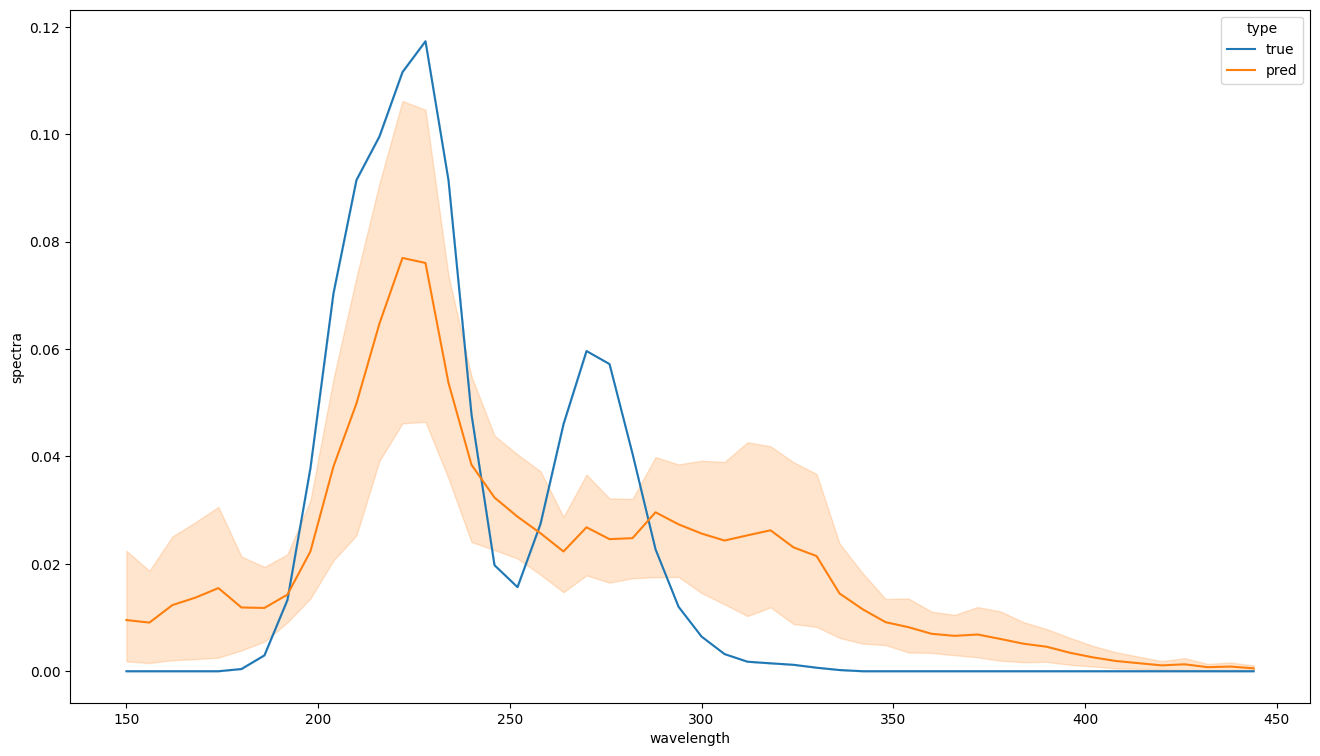

In [48]:
#plot the spectra for a specific smiles with pred vs true
#smiles = 'C#CC#CC#CC1CO1'
#Sample a smiles
smiles = random.choice(df_tidy_attentive_fp_test['smiles'].unique())
df_plot = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['smiles'] == smiles]
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_plot, x='wavelength', y='spectra', hue='type')

In [49]:
df_tidy_attentive_fp_test.to_pickle('df_ensemble_tidy_normalized.pkl')

In [ ]:
display(df_tidy_chemprop_test.head(5))  

In [5]:
# Load  df_emsemble_tidy_normalized.pkl
df_tidy_attentive_fp_test = pd.read_pickle('df_ensemble_tidy_normalized.pkl')

smiles  wavelength   spectra  type  \
32287    C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         150  0.001063  true   
5278587  C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         150  0.000479  pred   
137213   C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         156  0.004749  true   
5383513  C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         156  0.002541  pred   
242139   C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         162  0.013751  true   
5488439  C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         162  0.008500  pred   
347065   C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         168  0.027171  true   
5593365  C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         168  0.021336  pred   
451991   C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         174  0.041498  true   
5698291  C#CC(C)(C)N(C)Cc1ccc(OCC#CCOC)cc1C         174  0.041853  pred   

               model  
32287    AttentiveFP  
5278587  AttentiveFP  
137213   AttentiveFP  
5383513  AttentiveFP  
242139   AttentiveFP  
5488439  AttentiveFP  
347065   AttentiveFP  
5593365  AttentiveFP  
451991   AttentiveFP  
5698291  AttentiveFP

<Axes: xlabel='wavelength', ylabel='spectra'>

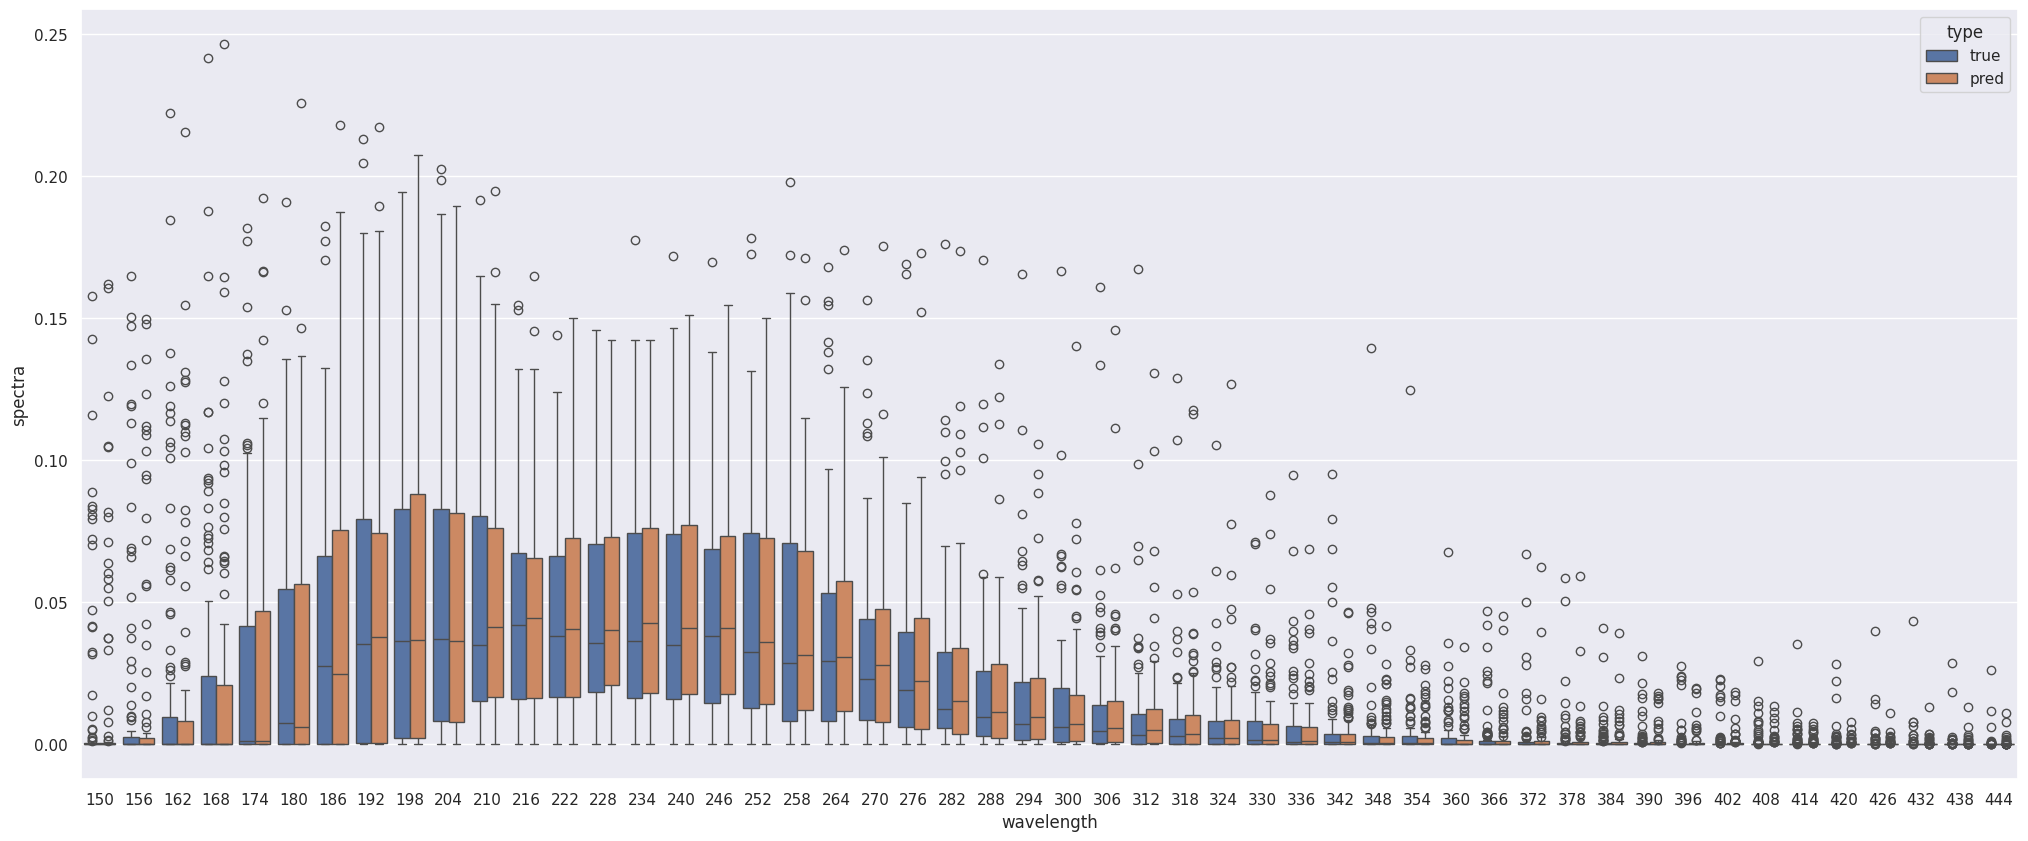

In [92]:
# Sample 1000 unique smiles
unique_smiles = df_tidy_attentive_fp_test['smiles'].unique()
smiles_sample = random.sample(list(unique_smiles), 100)
df_plot = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['smiles'].isin(smiles_sample)]
display(df_plot.head(10))

sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data

# Plot the responses for different events and regions
plt.figure(figsize=(25,10))
sns.boxplot(data=df_plot, x="wavelength", y="spectra", hue="type")


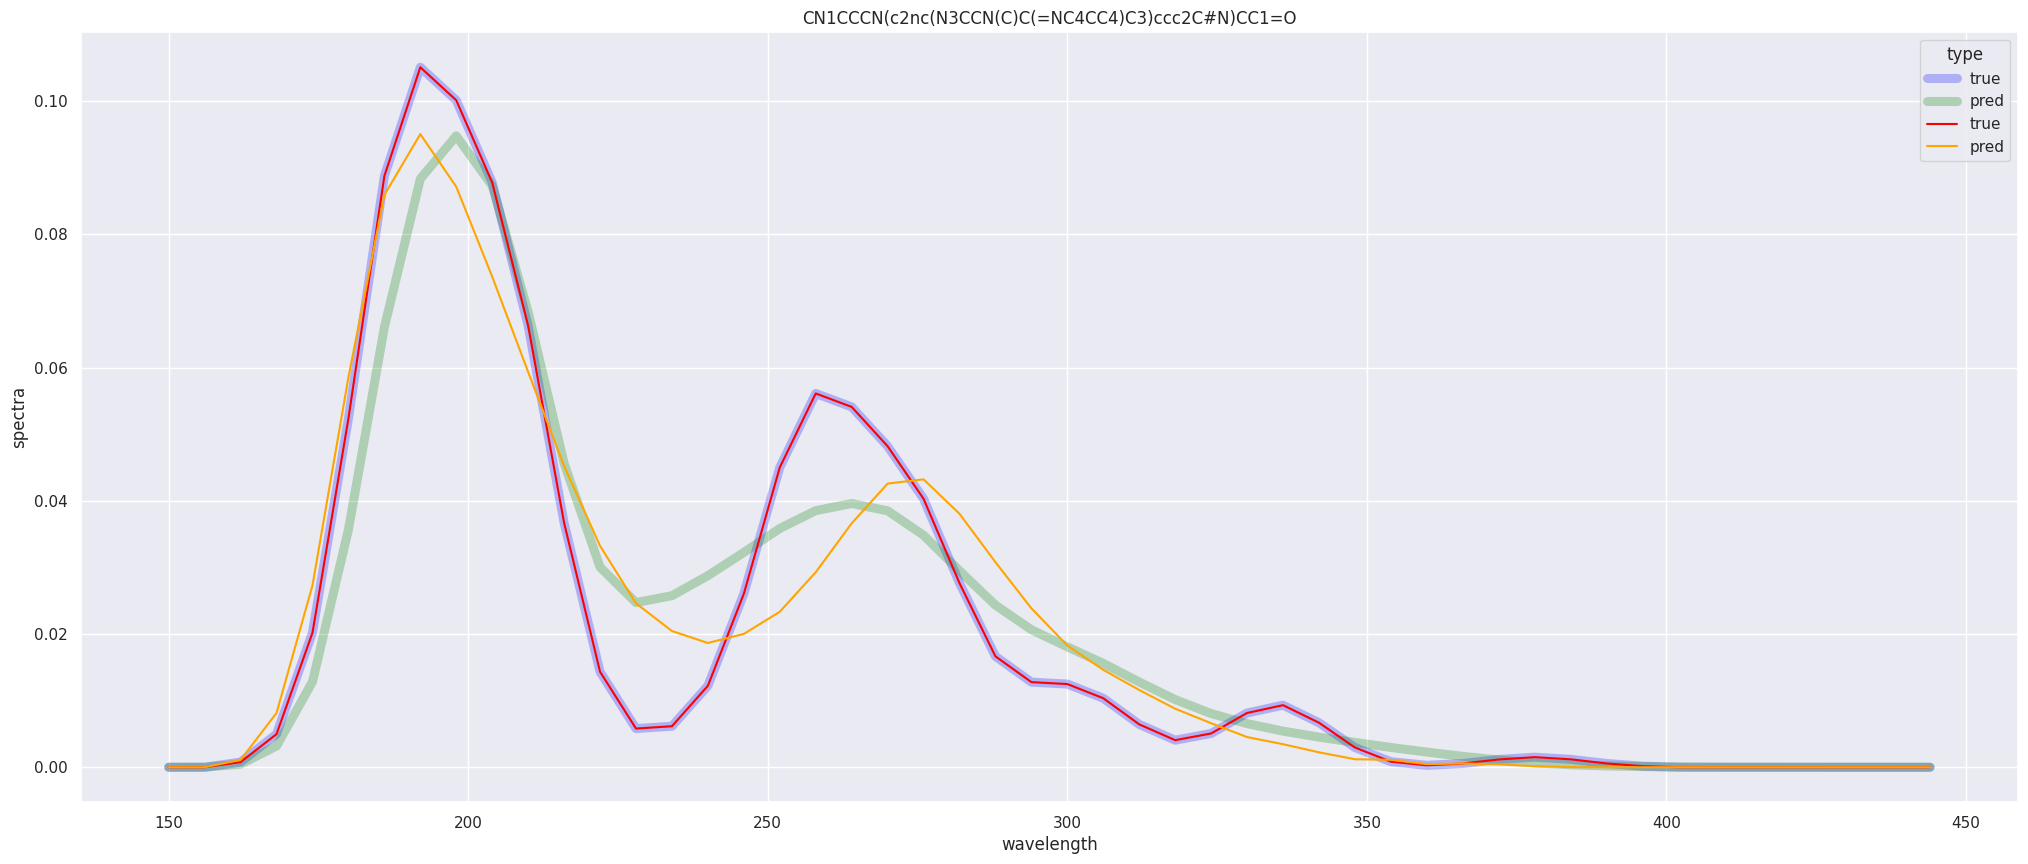

In [42]:
# make line plots of molecule C#CCC1(CNC(=O)NCc2ccc(-n3ccnc3)c(F)c2)CCCCC1
plt.figure(figsize=(25,10))
#sns.lineplot(data=df_tidy_test[df_tidy_test['smiles'] == 'C#CCC1(CNC(=O)NCc2ccc(-n3ccnc3)c(F)c2)CCCCC1'], x="wavelength", y="spectra", hue="type")
# PLot 3 random molecules
smiles_sample = random.sample(list(unique_smiles), 1)
for smiles in smiles_sample:
    sns.lineplot(data=df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['smiles'] == smiles], x="wavelength", y="spectra", hue="type",
                 palette=['blue', 'green'], linewidth=6.5, alpha=0.25)
    sns.lineplot(data=df_tidy_chemprop_test[df_tidy_chemprop_test['smiles'] == smiles], x="wavelength", y="spectra", hue="type",
                 palette=['red', 'orange'], linewidth=1.5, alpha=1) 
    # Add smiles as title
    plt.title(smiles)

wavelength  type   spectra          
                        mean       std
0        150  pred  0.010416  0.055775
1        150  true  0.010332  0.055829
2        156  pred  0.010729  0.033790
3        156  true  0.010658  0.034078
4        162  pred  0.013791  0.035431

<Axes: xlabel='wavelength', ylabel="('spectra', 'mean')">

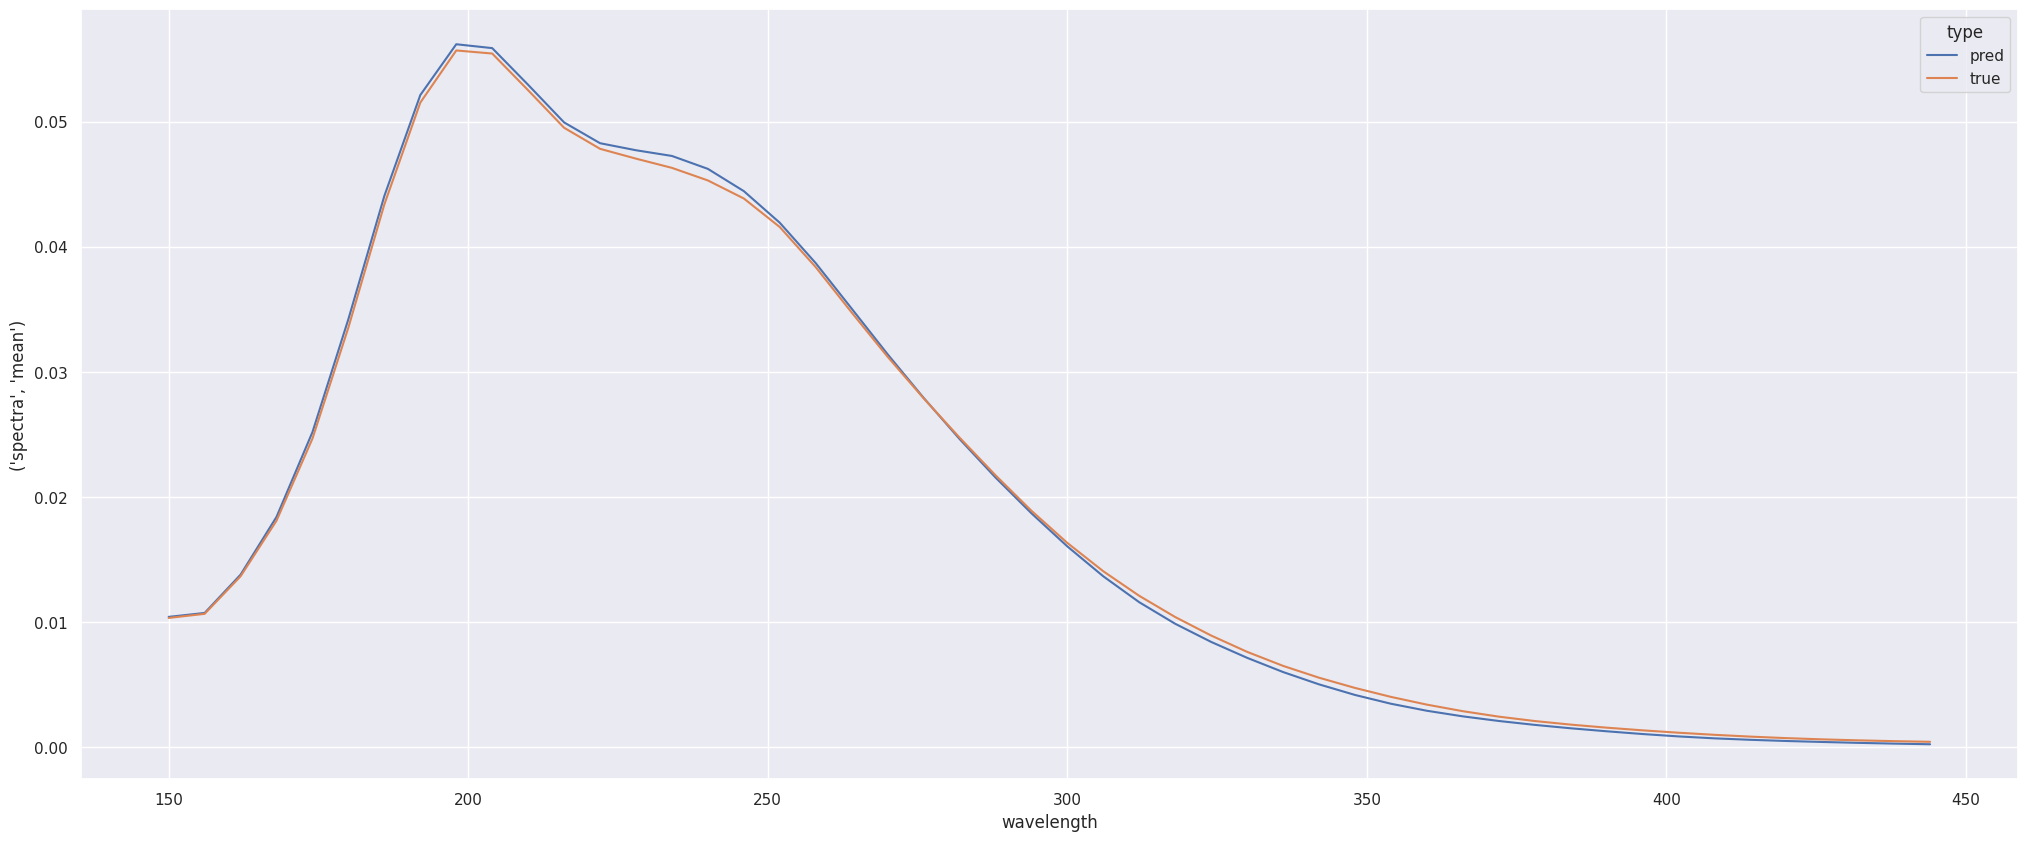

In [43]:
# For each wavelength gether the mean and std of the predicted and true spectra
df_plot_mean = df_tidy_attentive_fp_test.groupby(['wavelength', 'type']).agg({'spectra': ['mean', 'std']}).reset_index()
display(df_plot_mean.head(5))
# Plot the mean and std of the predicted and true spectra
plt.figure(figsize=(25,10))
sns.lineplot(data=df_plot_mean, x="wavelength", y=("spectra", "mean"), hue="type")



In [49]:
display(df_tidy_chemprop_test.head(5))

# Merge the two models dataframes and add a column to specify the model
df_tidy_attentive_fp_test['model'] = 'AttentiveFP'


smiles  wavelength       spectra  type     model
0  C#CC#CC#CC1CO1         150  1.012718e-02  true  Chemprop
1  C#CC#CC#CC1CO1         150  3.799958e-15  pred  Chemprop
2  C#CC#CC#CC1CO1         156  1.232343e-02  true  Chemprop
3  C#CC#CC#CC1CO1         156  3.035322e-03  pred  Chemprop
4  C#CC#CC#CC1CO1         162  1.631230e-02  true  Chemprop

In [ ]:
df_tidy_attentive_fp_test_tmp = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['smiles'].isin(df_tidy_chemprop_test['smiles'])]


In [50]:
df_tidy_attentive_fp_test = df_tidy_attentive_fp_test.sort_values(by=['smiles', 'wavelength']).reset_index(drop=True)

In [51]:
df_tidy_true_tmp = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['type'] == 'true'][df_tidy_attentive_fp_test['model'] == 'AttentiveFP'][['smiles', 'wavelength', 'spectra']]
df_tidy_pred_tmp = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['type'] == 'pred'][df_tidy_attentive_fp_test['model'] == 'AttentiveFP'][['smiles', 'wavelength', 'spectra']]
df_tidy_pred_tmp = df_tidy_pred_tmp.rename(columns={'spectra': 'spectra_pred'})
df_tidy_true_tmp = df_tidy_true_tmp.rename(columns={'spectra': 'spectra_true'})
df_tidy_error_attentive_fp = pd.merge(df_tidy_pred_tmp, df_tidy_true_tmp, on=['smiles', 'wavelength'])
df_tidy_error_attentive_fp['abs_error'] = df_tidy_error_attentive_fp.apply(abs_error, axis=1)
display(df_tidy_error_attentive_fp.head(5))

smiles  wavelength  spectra_pred  spectra_true  abs_error
0  C#CC#CC#CC1CO1         150      0.009277      0.010127   0.000850
1  C#CC#CC#CC1CO1         156      0.013605      0.012323   0.001282
2  C#CC#CC#CC1CO1         162      0.020621      0.016312   0.004309
3  C#CC#CC#CC1CO1         168      0.033490      0.019144   0.014347
4  C#CC#CC#CC1CO1         174      0.044235      0.025153   0.019083

In [53]:
df_tidy_error_attentive_fp.to_pickle(f'df_tidy_error_attentive_fp_checkpoint_4090_4gbw64fu.pkl')

In [ ]:

df_tidy_chemprop_test['model'] = 'Chemprop'


In [28]:
display(df_tidy_chemprop_test.head(5))
display(df_tidy_chemprop_test.shape)
# Sort by smiles and wavelength and reset index
df_tidy_chemprop_test = df_tidy_chemprop_test.sort_values(by=['smiles', 'wavelength']).reset_index(drop=True)

smiles  wavelength       spectra  type     model
65744    C#CC#CC#CC1CO1         150  1.012718e-02  true  Chemprop
5356944  C#CC#CC#CC1CO1         150  3.799958e-15  pred  Chemprop
171568   C#CC#CC#CC1CO1         156  1.232343e-02  true  Chemprop
5462768  C#CC#CC#CC1CO1         156  3.035322e-03  pred  Chemprop
277392   C#CC#CC#CC1CO1         162  1.631230e-02  true  Chemprop

(10582400, 5)

In [29]:
display(df_tidy_chemprop_test.head(5))


smiles  wavelength       spectra  type     model
0  C#CC#CC#CC1CO1         150  1.012718e-02  true  Chemprop
1  C#CC#CC#CC1CO1         150  3.799958e-15  pred  Chemprop
2  C#CC#CC#CC1CO1         156  1.232343e-02  true  Chemprop
3  C#CC#CC#CC1CO1         156  3.035322e-03  pred  Chemprop
4  C#CC#CC#CC1CO1         162  1.631230e-02  true  Chemprop

In [30]:
df_tidy_true_tmp = df_tidy_chemprop_test[df_tidy_chemprop_test['type'] == 'true'][df_tidy_chemprop_test['model'] == 'Chemprop'][['smiles', 'wavelength', 'spectra']]
df_tidy_pred_tmp = df_tidy_chemprop_test[df_tidy_chemprop_test['type'] == 'pred'][df_tidy_chemprop_test['model'] == 'Chemprop'][['smiles', 'wavelength', 'spectra']]
df_tidy_pred_tmp = df_tidy_pred_tmp.rename(columns={'spectra': 'spectra_pred'})
df_tidy_true_tmp = df_tidy_true_tmp.rename(columns={'spectra': 'spectra_true'})
df_tidy_error_chemprop = pd.merge(df_tidy_pred_tmp, df_tidy_true_tmp, on=['smiles', 'wavelength'])
df_tidy_error_chemprop['abs_error'] = df_tidy_error_chemprop.apply(abs_error, axis=1)
display(df_tidy_error_chemprop.head(5))

smiles  wavelength  spectra_pred  spectra_true  abs_error
0  C#CC#CC#CC1CO1         150  3.799958e-15      0.010127   0.010127
1  C#CC#CC#CC1CO1         156  3.035322e-03      0.012323   0.009288
2  C#CC#CC#CC1CO1         162  1.138306e-02      0.016312   0.004929
3  C#CC#CC#CC1CO1         168  2.549160e-02      0.019144   0.006348
4  C#CC#CC#CC1CO1         174  4.985404e-02      0.025153   0.024701

In [31]:
# pickle dataframe for later use
df_tidy_error_chemprop.to_pickle(f'df_tidy_error_chemprop_{chemprop_dim}.pkl')

In [ ]:
df_tidy_chemprop_test_tmp = df_tidy_chemprop_test[df_tidy_chemprop_test['smiles'].isin(df_tidy_attentive_fp_test_tmp['smiles'])]


In [ ]:

df_tidy_all = pd.concat([df_tidy_attentive_fp_test_tmp, df_tidy_chemprop_test_tmp], ignore_index=True)
display(df_tidy_all.head(5))


wavelength  type        model   spectra          
                                     mean       std
0        150  pred  AttentiveFP  0.010416  0.055775
1        150  pred     Chemprop  0.009040  0.044112
2        150  true  AttentiveFP  0.010332  0.055829
3        150  true     Chemprop  0.009385  0.045524
4        156  pred  AttentiveFP  0.010729  0.033790

<Axes: xlabel='wavelength', ylabel="('spectra', 'mean')">

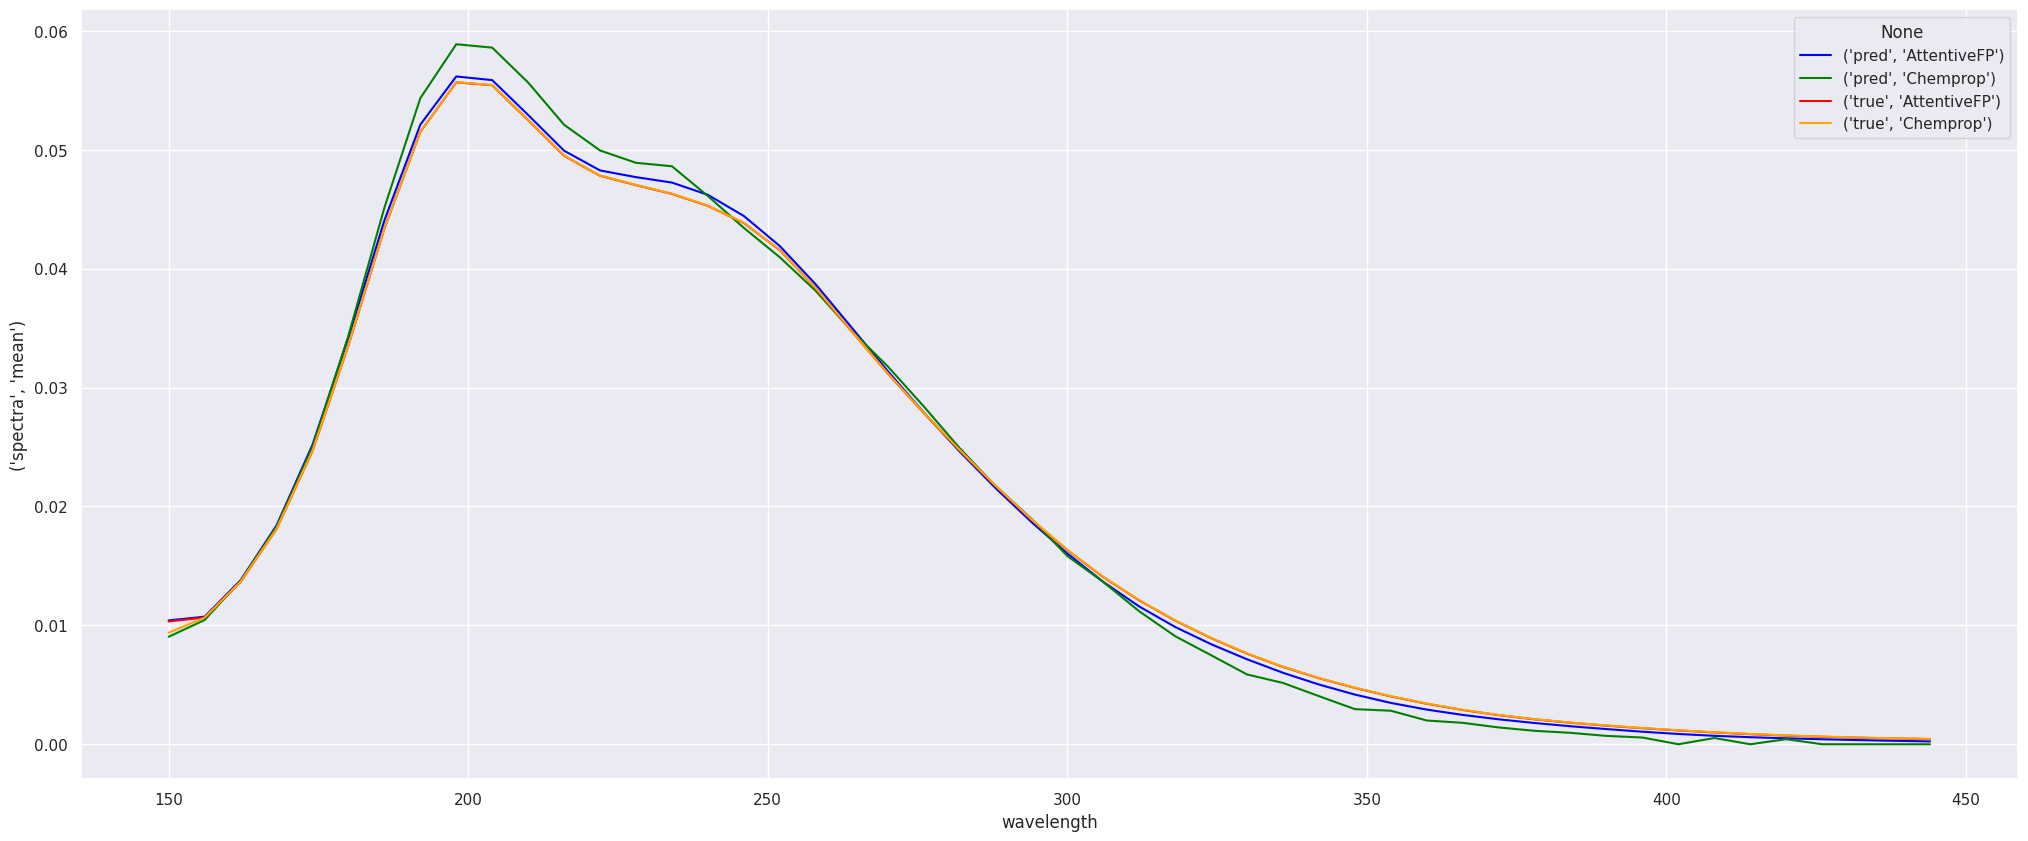

In [45]:
# For each wavelength gether the mean and std of the predicted and true spectra
df_plot_mean = df_tidy_all.groupby(['wavelength', 'type', 'model']).agg({'spectra': ['mean', 'std']}).reset_index()
display(df_plot_mean.head(5))
# Plot the mean and std of the predicted and true spectra
plt.figure(figsize=(25,10))
sns.lineplot(data=df_plot_mean, x="wavelength", y=("spectra", "mean"), hue=df_plot_mean[['type', 'model']].apply(tuple, axis=1), palette=['blue', 'green', 'red', 'orange'], dashes=True)


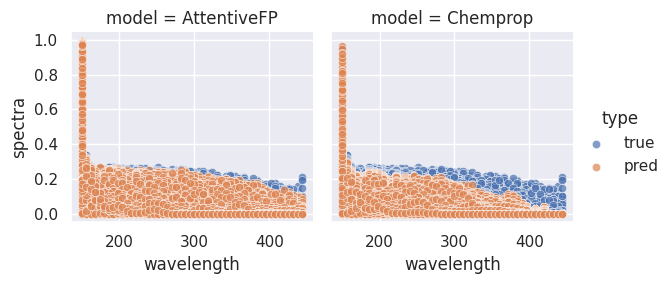

In [46]:
g = sns.FacetGrid(df_tidy_all, col="model", hue="type")
g.map(sns.scatterplot, "wavelength", "spectra", alpha=.7)
g.add_legend()


In [14]:
def abs_error(row):
    return np.abs(row['spectra_true'] - row['spectra_pred'])

In [49]:

# Compute absolut error between predicted and true spectra
# Temporary dataframe to store the absolute error
df_tidy_true_tmp = df_tidy_all[df_tidy_all['type'] == 'true'][df_tidy_all['model'] == 'AttentiveFP'][['smiles', 'wavelength', 'spectra']]
df_tidy_pred_tmp = df_tidy_all[df_tidy_all['type'] == 'pred'][df_tidy_all['model'] == 'AttentiveFP'][['smiles', 'wavelength', 'spectra']]
df_tidy_pred_tmp = df_tidy_pred_tmp.rename(columns={'spectra': 'spectra_pred'})
df_tidy_true_tmp = df_tidy_true_tmp.rename(columns={'spectra': 'spectra_true'})
df_tidy_error_attentive_fp = pd.merge(df_tidy_pred_tmp, df_tidy_true_tmp, on=['smiles', 'wavelength'])
df_tidy_error_attentive_fp['abs_error'] = df_tidy_error_attentive_fp.apply(abs_error, axis=1)

display(df_tidy_error_attentive_fp.head(5))

# Same for chemprop
# Temporary dataframe to store the absolute error
df_tidy_true_tmp = df_tidy_all[df_tidy_all['type'] == 'true'][df_tidy_all['model'] == 'Chemprop'][['smiles', 'wavelength', 'spectra']]
df_tidy_pred_tmp = df_tidy_all[df_tidy_all['type'] == 'pred'][df_tidy_all['model'] == 'Chemprop'][['smiles', 'wavelength', 'spectra']]
df_tidy_pred_tmp = df_tidy_pred_tmp.rename(columns={'spectra': 'spectra_pred'})
df_tidy_true_tmp = df_tidy_true_tmp.rename(columns={'spectra': 'spectra_true'})
df_tidy_error_chemprop = pd.merge(df_tidy_pred_tmp, df_tidy_true_tmp, on=['smiles', 'wavelength'])
df_tidy_error_chemprop['abs_error'] = df_tidy_error_chemprop.apply(abs_error, axis=1)

display(df_tidy_error_chemprop.head(5))

# Merge the two models dataframes and add a column to specify the model
df_tidy_error_attentive_fp['model'] = 'AttentiveFP'
df_tidy_error_chemprop['model'] = 'Chemprop'
# Merge the two models error dataframes
df_tidy_error_all = pd.concat([df_tidy_error_attentive_fp, df_tidy_error_chemprop], ignore_index=True)

display(df_tidy_error_all.head(5))


smiles  wavelength  spectra_pred  spectra_true  abs_error
0  C#CC#CC#CC1CO1         150      0.009277      0.010127   0.000850
1  C#CC#CC#CC1CO1         156      0.013605      0.012323   0.001282
2  C#CC#CC#CC1CO1         162      0.020621      0.016312   0.004309
3  C#CC#CC#CC1CO1         168      0.033490      0.019144   0.014347
4  C#CC#CC#CC1CO1         174      0.044235      0.025153   0.019083

smiles  wavelength  spectra_pred  spectra_true  abs_error
0  C#CC#CC#CC1CO1         150  3.799958e-15      0.010127   0.010127
1  C#CC#CC#CC1CO1         156  3.035322e-03      0.012323   0.009288
2  C#CC#CC#CC1CO1         162  1.138306e-02      0.016312   0.004929
3  C#CC#CC#CC1CO1         168  2.549160e-02      0.019144   0.006348
4  C#CC#CC#CC1CO1         174  4.985404e-02      0.025153   0.024701

smiles  wavelength  spectra_pred  spectra_true  abs_error  \
0  C#CC#CC#CC1CO1         150      0.009277      0.010127   0.000850   
1  C#CC#CC#CC1CO1         156      0.013605      0.012323   0.001282   
2  C#CC#CC#CC1CO1         162      0.020621      0.016312   0.004309   
3  C#CC#CC#CC1CO1         168      0.033490      0.019144   0.014347   
4  C#CC#CC#CC1CO1         174      0.044235      0.025153   0.019083   

         model  
0  AttentiveFP  
1  AttentiveFP  
2  AttentiveFP  
3  AttentiveFP  
4  AttentiveFP

In [55]:
# sort by wavelength and smiles
df_tidy_error_all = df_tidy_error_all.sort_values(by=['wavelength', 'smiles'])
display(df_tidy_error_all.head(26))


smiles  wavelength  \
0                                           C#CC#CC#CC1CO1         150   
5246300                                     C#CC#CC#CC1CO1         150   
50                                         C#CC#CCC(F)(F)F         150   
5246350                                    C#CC#CCC(F)(F)F         150   
100             C#CC(=C(O)c1cccc(Nc2nnc(COC)s2)c1)c1nccn1C         150   
5246400         C#CC(=C(O)c1cccc(Nc2nnc(COC)s2)c1)c1nccn1C         150   
150                      C#CC(=CC1(O)CCS(=O)(=O)CC1)CCCCCC         150   
5246450                  C#CC(=CC1(O)CCS(=O)(=O)CC1)CCCCCC         150   
200                          C#CC(=NN1CCOC1=O)NCN(CC)C1CC1         150   
5246500                      C#CC(=NN1CCOC1=O)NCN(CC)C1CC1         150   
250                                    C#CC(=O)C(=O)C(=N)N         150   
5246550                                C#CC(=O)C(=O)C(=N)N         150   
300                                      C#CC(=O)C1(CC)CC1         150   
5246600                                  C#CC(=O)C1(CC)CC1         150   
350                                       C#CC(=O)C1CN1C=O         150   
5246650                                   C#CC(=O)C1CN1C=O         150   
400                                            C#CC(=O)C=O         150   
5246700                                        C#CC(=O)C=O         150   
450                     C#CC(=O)CCN1CCc2ccc(C(C)(C)C)cc2C1         150   
5246750                 C#CC(=O)CCN1CCc2ccc(C(C)(C)C)cc2C1         150   
500                   C#CC(=O)N(C)CCOCCNC(=O)NCCN(C)C(C)=O         150   
5246800               C#CC(=O)N(C)CCOCCNC(=O)NCCN(C)C(C)=O         150   
550          C#CC(=O)N1CC(NC(=O)C(=O)NCCC2CCN(C(C)C)CC2)C1         150   
5246850      C#CC(=O)N1CC(NC(=O)C(=O)NCCC2CCN(C(C)C)CC2)C1         150   
600      C#CC(=O)N1CCC(CC(=O)N2CCN(NC(COC)COC)CC2)(c2cc...         150   

         spectra_pred  spectra_true     abs_error        model  
0        9.277335e-03  1.012719e-02  8.498505e-04  AttentiveFP  
5246300  3.799958e-15  1.012718e-02  1.012718e-02     Chemprop  
50       1.352229e-01  1.279876e-01  7.235289e-03  AttentiveFP  
5246350  1.918963e-01  1.279876e-01  6.390876e-02     Chemprop  
100      8.983182e-09  1.118730e-09  7.864453e-09  AttentiveFP  
5246400  6.320934e-15  2.069151e-09  2.069145e-09     Chemprop  
150      9.726979e-02  8.399817e-02  1.327162e-02  AttentiveFP  
5246450  7.809585e-02  8.399816e-02  5.902313e-03     Chemprop  
200      8.764233e-02  7.710901e-02  1.053332e-02  AttentiveFP  
5246500  7.644960e-02  7.710901e-02  6.594136e-04     Chemprop  
250      1.718091e-01  2.032848e-01  3.147574e-02  AttentiveFP  
5246550  1.210505e-01  2.032848e-01  8.223433e-02     Chemprop  
300      1.954405e-01  1.941588e-01  1.281679e-03  AttentiveFP  
5246600  1.734838e-01  1.941588e-01  2.067499e-02     Chemprop  
350      1.537339e-01  1.651300e-01  1.139607e-02  AttentiveFP  
5246650  1.140652e-01  1.651300e-01  5.106477e-02     Chemprop  
400      1.181306e-01  8.629388e-02  3.183676e-02  AttentiveFP  
5246700  1.454744e-01  8.629387e-02  5.918055e-02     Chemprop  
450      3.016646e-05  2.330769e-09  3.016413e-05  AttentiveFP  
5246750  2.450463e-15  2.445148e-09  2.445146e-09     Chemprop  
500      1.345533e-02  4.256403e-02  2.910869e-02  AttentiveFP  
5246800  5.334916e-02  4.256403e-02  1.078513e-02     Chemprop  
550      1.570931e-04  3.501721e-04  1.930790e-04  AttentiveFP  
5246850  6.910361e-03  3.501721e-04  6.560189e-03     Chemprop  
600      1.335040e-08  2.052457e-09  1.129794e-08  AttentiveFP

In [56]:

#Pickle 
df_tidy_error_all.to_pickle('df_tidy_error_all.pkl')


In [4]:
# Load pkl file
df_tidy_error_all = pd.read_pickle('df_tidy_error_all.pkl')

In [5]:
# Mean of spectra_pred grouped by wavelength
df_tidy_spectra_true_mean = df_tidy_error_all.groupby(['wavelength', 'model'])['spectra_true'].mean().reset_index()
df_tidy_spectra_true_std = df_tidy_error_all.groupby(['wavelength', 'model'])['spectra_true'].std().reset_index()
# Merge the mean and std
df_tidy_spectra_true_mean = pd.merge(df_tidy_spectra_true_mean, df_tidy_spectra_true_std, on=['wavelength', 'model'])
# Change column names
df_tidy_spectra_true_mean.columns = ['wavelength', 'model', 'mean_true', 'std_true']
display(df_tidy_spectra_true_mean.head(5))

# Merge the mean and std of the predicted spectra with df_tidy_error_all
df_new = pd.merge(df_tidy_error_all, df_tidy_spectra_true_mean, on=['wavelength', 'model'])


wavelength        model  mean_true  std_true
0         150  AttentiveFP   0.010332  0.055829
1         150     Chemprop   0.009385  0.045524
2         156  AttentiveFP   0.010658  0.034078
3         156     Chemprop   0.010654  0.034076
4         162  AttentiveFP   0.013660  0.035676

In [6]:
def center_and_divide_by_std_pred(row):
    return (row['spectra_pred'] - row['mean_true'])/row['std_true']

def center_and_divide_by_std_true(row):
    return (row['spectra_true'] - row['mean_true'])/row['std_true']


In [7]:

# Compute the centered and divided by std of the predicted spectra
df_new['centered_divided_pred'] = df_new.apply(center_and_divide_by_std_pred, axis=1)
df_new['centered_divided_true'] = df_new.apply(center_and_divide_by_std_true, axis=1)


In [8]:
# Sort based on centered_divided_true
df_new = df_new.sort_values(by='centered_divided_true', ascending=True)
display(df_new.head(26))


smiles  wavelength  \
2485517  Cc1nn(-c2ccc(F)cc2)c(N)c1C=NNc1nc(=O)c2cnn(-c3...         216   
2469447  Cc1ccc(CCC(=O)Nc2ccc(NC(=O)ON=Cc3cccc(-n4cccn4...         216   
2446219  COc1ccc(CN2C=C(c3nc(-c4ccnc5nccc-5c4)no3)CC2)cc1F         216   
2490315  Cn1cc(C=C2CCCc3c2nc2ccccc2c3C(=O)Nc2ccc(NS(=O)...         216   
2314611  C=C(Nc1ccc(F)c(NC(=S)NC)c1)c1cnc2c(c1)c(C(F)(F...         216   
2323149  CC(=NNc1ncccc1C(=O)Nc1cnn(-c2ccccc2)c1C)c1cn2c...         216   
2415193  CN=C1N(C)C(=O)N1c1cccc(NC(=O)c2nnn(-c3ccc4nccc...         216   
2460613  Cc1cc(-n2nccn2)ccc1NC(=O)c1ccc(C(=O)Nc2ccc(-n3...         216   
2514235  O=C1N=CNc2ccc(C(=O)Nc3cn(-c4ccco4)nc3-c3ccccc3...         216   
2444479  COc1ccc(C(=O)NN=Cc2cn(-c3ccccc3F)nc2-c2ccc(C)c...         216   
2510573  O=C(Nc1cccc(-c2noc(-c3cn(Cc4ccccc4)cn3)n2)c1)c...         216   
2466951  Cc1ccc(-c2cc(Nc3ccccc3C(=O)Nc3cccnc3Oc3ccc(CC#...         216   
2348813  CCC(=NNc1ncncc1F)c1ccc(-c2noc(-c3ccn(-c4cccc(C...         216   
2440621  COc1cc(C=C2CCc3c2nc2ccccc2c3C(=O)Nc2cc(C(C)=O)...         216   
2402369  CCn1nnnc1N1C=C(c2cc(CN=Nc3ccc(-n4cccn4)nn3)n[n...         216   
2509299  O=C(NCc1cn(-c2ccccc2)nc1-c1ccccn1)c1cnc(-c2ccc...         216   
2366955  CCCc1c(-c2ccncc2)n[nH]c1NC(C=Cc1cnc2ccccc2n1)=NOC         216   
2323157  CC(=NNc1ncccn1)c1ccc(C(=O)Nc2ccc(-c3ccccc3)cc2...         216   
2323173  CC(=NNc1ncncc1F)c1ccc(N2CCC(OC(=O)c3nc(-c4cccc...         216   
2449493  COc1ccc2cc(-c3nn(-c4ccccc4C)cc3C=CNNC(=S)c3ccc...         216   
2500343  NNC1=CNC(c2ccc(NC(=O)c3cnc4c(c3O)=CC=CNC=4)cc2...         216   
2379435    CCOC(=NNCCO)c1ccc(-c2nc(-c3ccc4ncccc4c3)no2)cn1         216   
2467081  Cc1ccc(-c2csc(NC(=O)C=CC3=CC4=CNN(N(C)C)C=CC4=...         216   
2423285  COC(=O)Nc1ccc(NNC(=CN2CCCC2=O)NN=Cc2nccn2CC#Cc...         216   
2443801  COc1ccc(-c2noc(-c3cc(-c4ccccc4)n(-c4ccccc4F)n3...         216   
2517627  S=C1N=CCN1c1ccc(-c2nc(-c3nnc(-c4ccccc4)o3)cs2)cc1         216   

         spectra_pred  spectra_true     abs_error     model  mean_true  \
2485517  9.187924e-15  1.386922e-09  1.386912e-09  Chemprop   0.049519   
2469447  8.996774e-15  1.405748e-09  1.405739e-09  Chemprop   0.049519   
2446219  1.016666e-14  1.407812e-09  1.407802e-09  Chemprop   0.049519   
2490315  1.694773e-14  1.412374e-09  1.412357e-09  Chemprop   0.049519   
2314611  8.175439e-15  1.441569e-09  1.441561e-09  Chemprop   0.049519   
2323149  1.619615e-14  1.454266e-09  1.454250e-09  Chemprop   0.049519   
2415193  1.273528e-14  1.500017e-09  1.500005e-09  Chemprop   0.049519   
2460613  1.199560e-14  1.500890e-09  1.500878e-09  Chemprop   0.049519   
2514235  1.172101e-14  1.556049e-09  1.556038e-09  Chemprop   0.049519   
2444479  1.289044e-14  1.574530e-09  1.574517e-09  Chemprop   0.049519   
2510573  1.037288e-14  1.575261e-09  1.575251e-09  Chemprop   0.049519   
2466951  1.136633e-14  1.593289e-09  1.593277e-09  Chemprop   0.049519   
2348813  1.175926e-14  1.618180e-09  1.618168e-09  Chemprop   0.049519   
2440621  1.421710e-14  1.646773e-09  1.646759e-09  Chemprop   0.049519   
2402369  1.478751e-14  1.647624e-09  1.647609e-09  Chemprop   0.049519   
2509299  1.224934e-14  1.649422e-09  1.649410e-09  Chemprop   0.049519   
2366955  1.591528e-14  1.665315e-09  1.665299e-09  Chemprop   0.049519   
2323157  1.488217e-14  1.667706e-09  1.667691e-09  Chemprop   0.049519   
2323173  1.790279e-14  1.688324e-09  1.688306e-09  Chemprop   0.049519   
2449493  1.473588e-14  1.695673e-09  1.695658e-09  Chemprop   0.049519   
2500343  1.415097e-14  1.696307e-09  1.696293e-09  Chemprop   0.049519   
2379435  1.609398e-14  1.699594e-09  1.699578e-09  Chemprop   0.049519   
2467081  1.346980e-14  1.701544e-09  1.701531e-09  Chemprop   0.049519   
2423285  1.552004e-14  1.701717e-09  1.701701e-09  Chemprop   0.049519   
2443801  9.855994e-15  1.706054e-09  1.706044e-09  Chemprop   0.049519   
2517627  1.247874e-14  1.714000e-09  1.713987e-09  Chemprop   0.049519   

         std_true  centered_divided_pred  centered_div

In [79]:

"""
# iterate through rows in df_tidy_spectra_true_mean
for ind, row in df_tidy_spectra_true_mean.iterrows():
    print(row[0], row[1], row[2], row[3])
    wavelength = row[0]
    model = row[1]
    mean_true = row[2]
    std_true = row[3]
"""    


'\n# iterate through rows in df_tidy_spectra_true_mean\nfor ind, row in df_tidy_spectra_true_mean.iterrows():\n    print(row[0], row[1], row[2], row[3])\n    wavelength = row[0]\n    model = row[1]\n    mean_true = row[2]\n    std_true = row[3]\n'

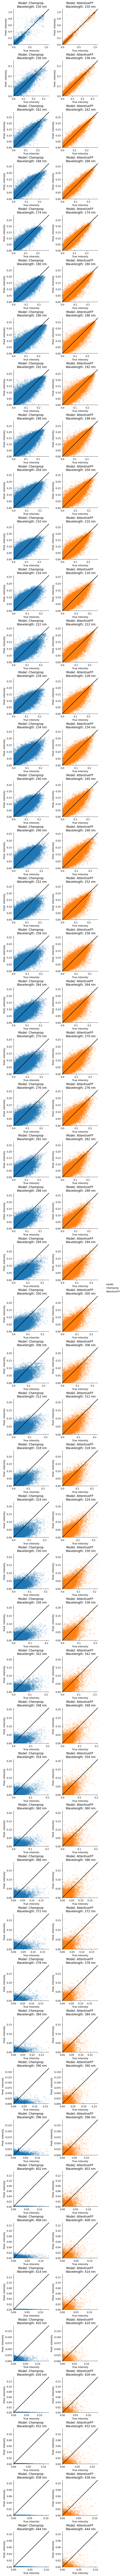

In [33]:
"""
wavelengths_attentive_fp = df_new['wavelength'].unique()
wavelengths_chemprop = df_new['wavelength'].unique()
wavelengths = np.concatenate((wavelengths_attentive_fp, wavelengths_chemprop))
# sort wavelengths
wavelengths = sorted(wavelengths)

#df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['smiles'].isin(smiles_sample)]
unique_smiles = df_new['smiles'].unique()
smiles_sample = random.sample(list(unique_smiles), 100)
g = sns.FacetGrid(df_new, row="wavelength", col="model", sharex= False, sharey=False, hue="model")
g.map(sns.scatterplot, "spectra_true", "spectra_pred", alpha=.1, linewidth=0)
g.add_legend()
for ax, wavelength in zip(g.axes.flat, wavelengths):
    ax.axline((0, 0), slope=1, color='black')
    ax.axline((0, 0), slope=1, color='black')
    # Get current title text
    title_text = ax.get_title()
    model = 'AttentiveFP' if 'AttentiveFP' in title_text else 'Chemprop'
    ax.set_title(f'Model: {model} \n Wavelength: {wavelength} nm')
    # Set axis limits to min to max of centered_divided_true and centered_divided_pred for each wavelength
    x_min = df_new[df_new['wavelength'] == wavelength]['spectra_pred'].min()
    x_max = df_new[df_new['wavelength'] == wavelength]['spectra_pred'].max()*1.1
    y_min = df_new[df_new['wavelength'] == wavelength]['spectra_pred'].min()
    y_max = df_new[df_new['wavelength'] == wavelength]['spectra_pred'].max()*1.1
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('True intensity')
    ax.set_ylabel('Pred. intensity')
    
"""

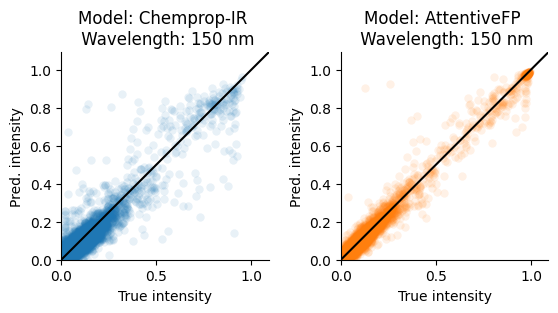

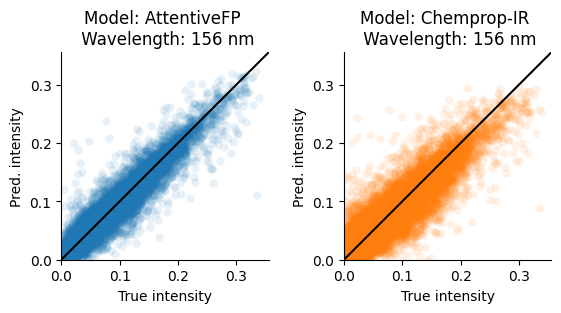

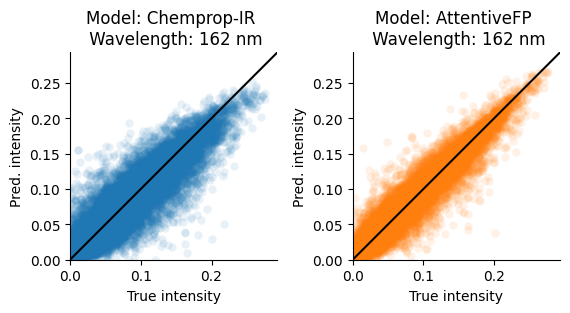

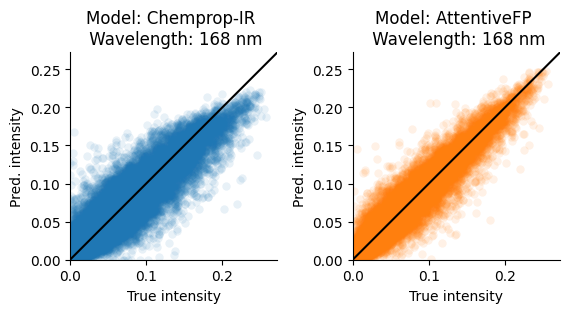

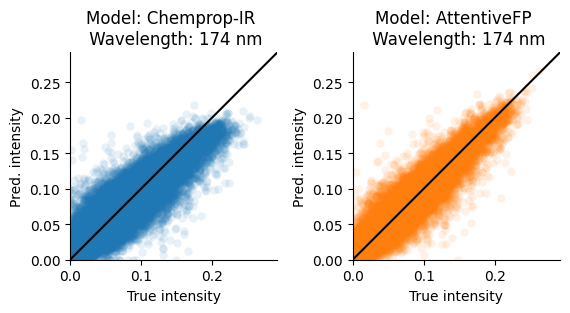

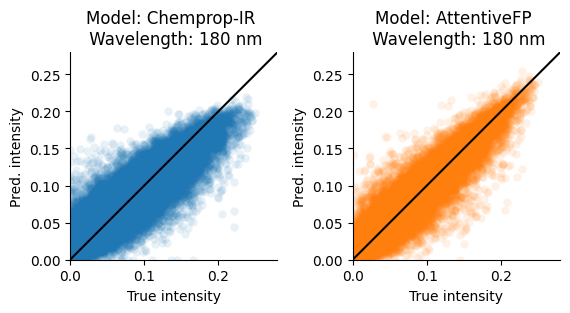

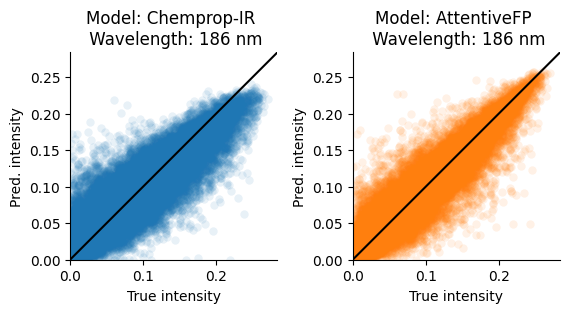

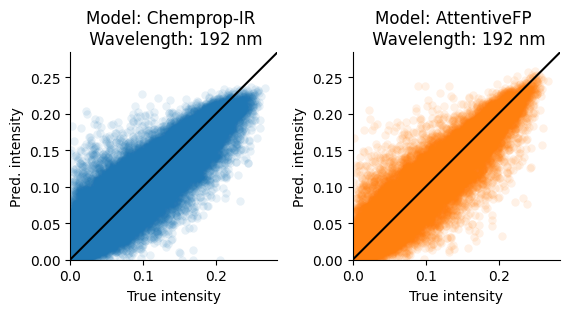

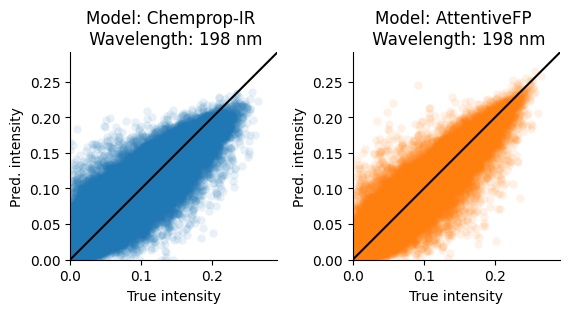

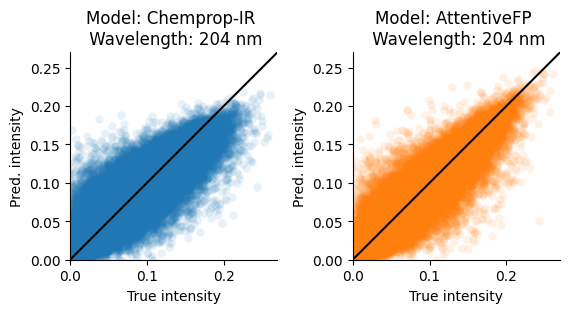

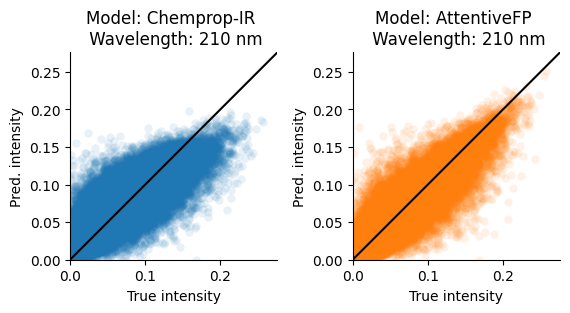

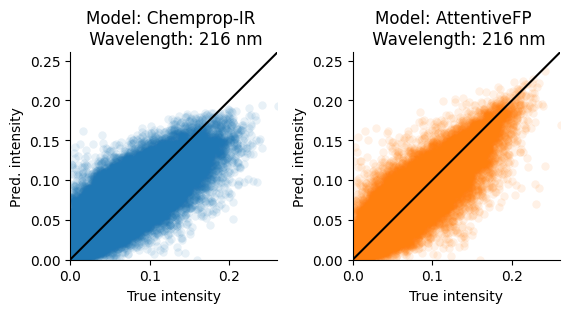

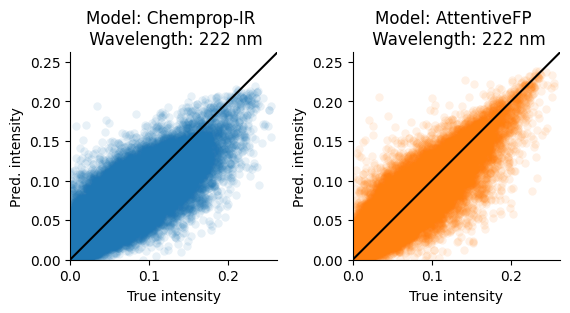

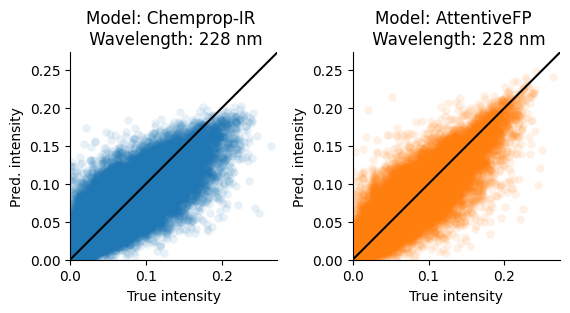

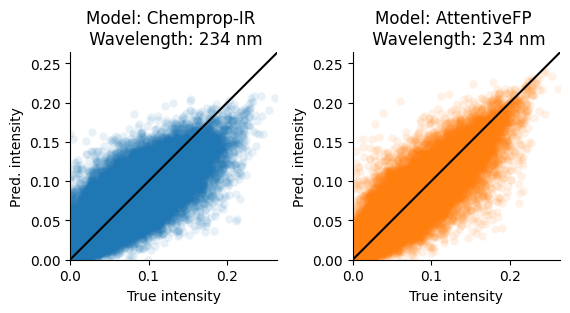

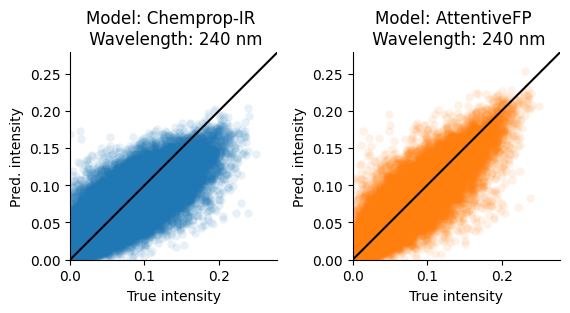

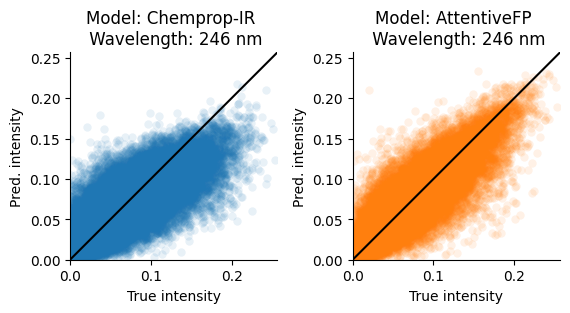

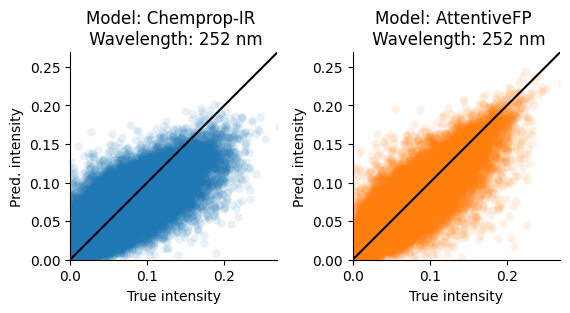

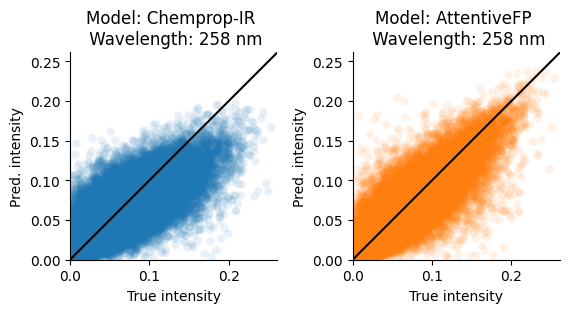

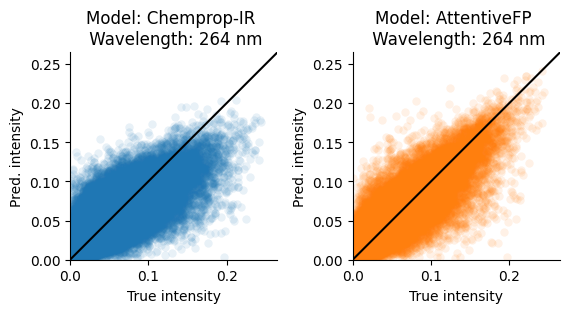

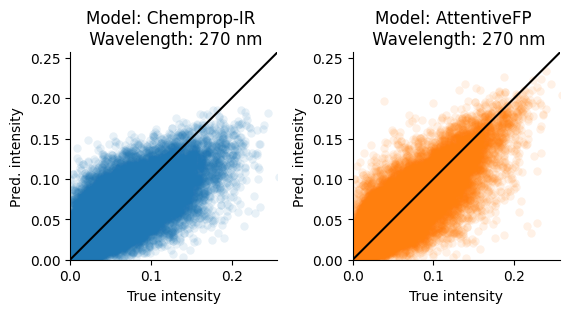

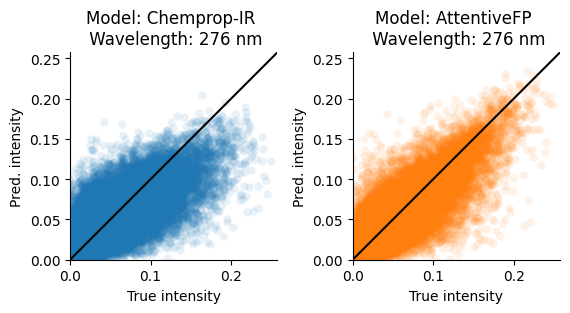

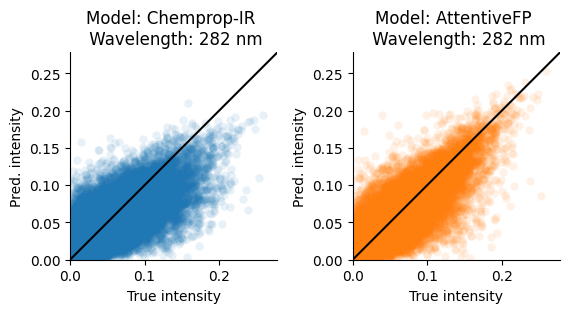

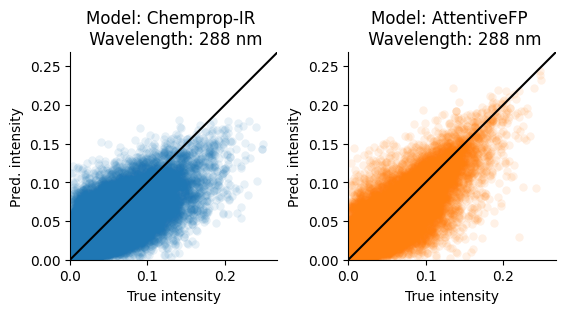

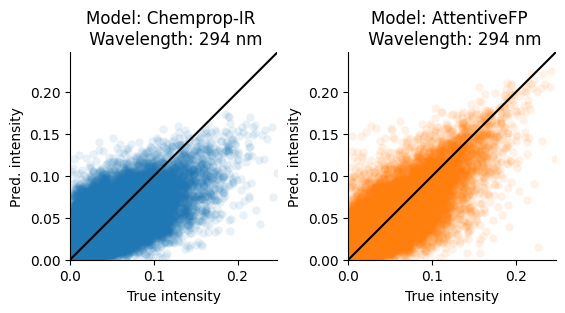

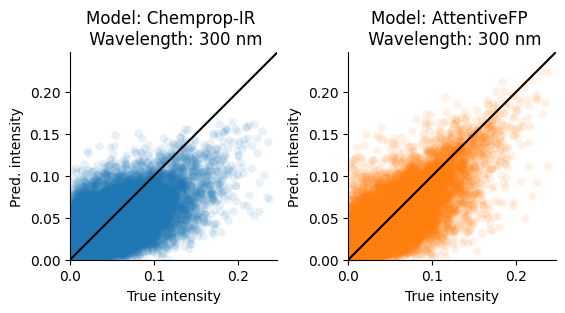

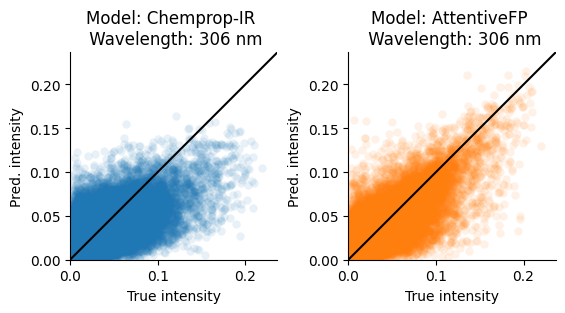

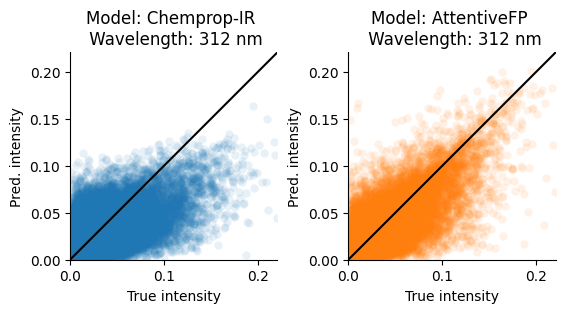

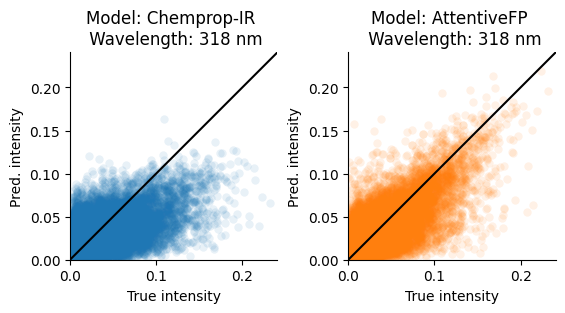

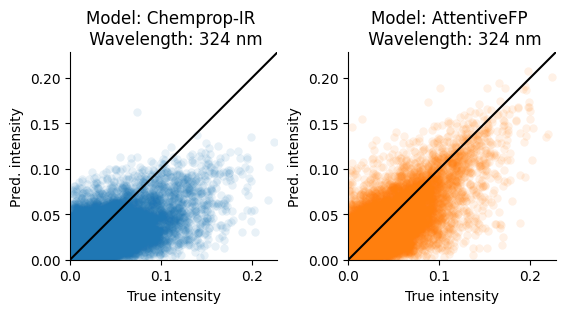

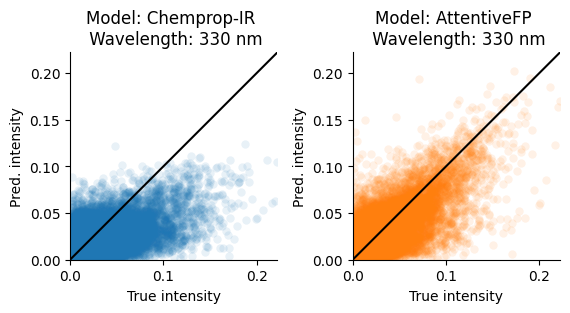

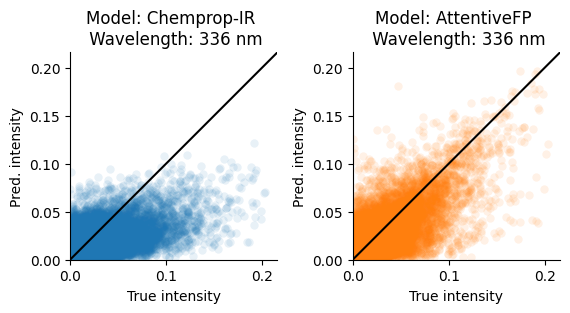

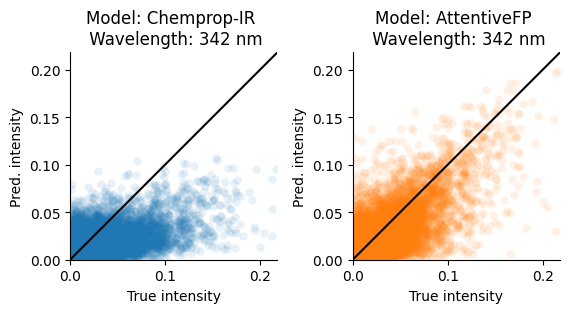

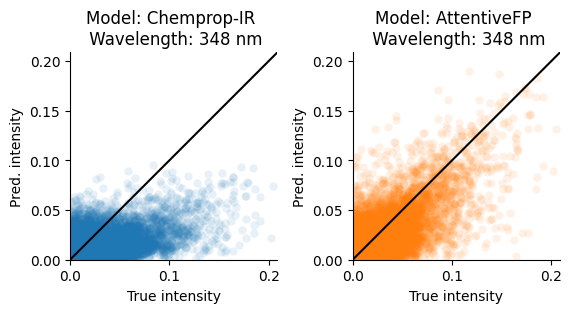

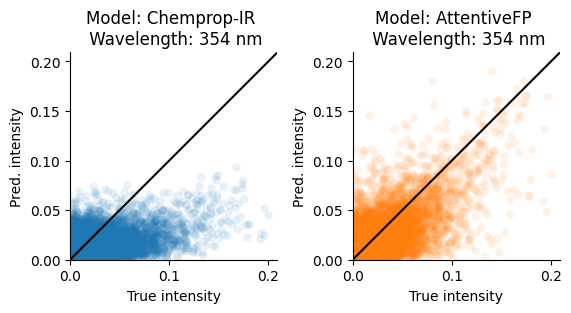

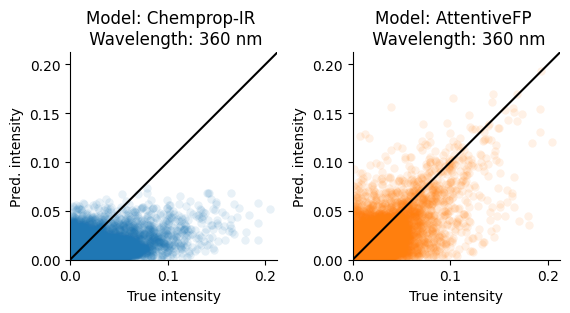

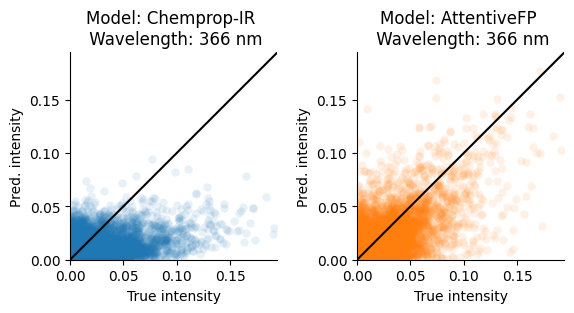

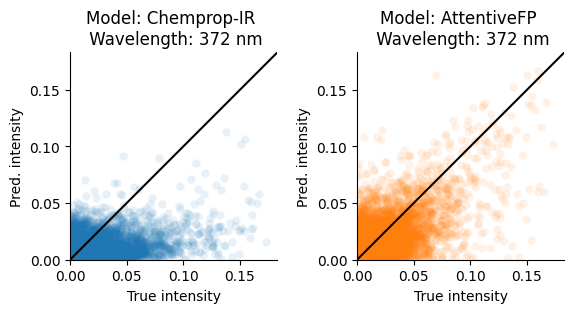

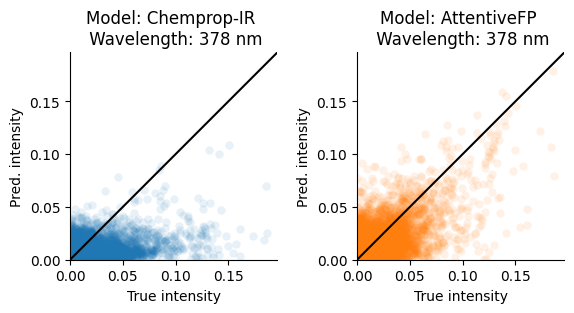

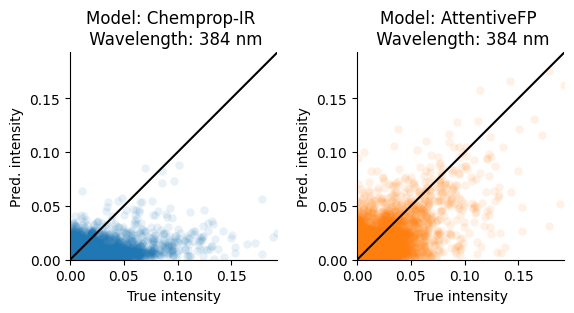

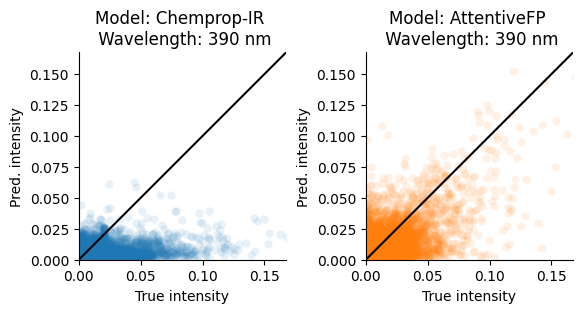

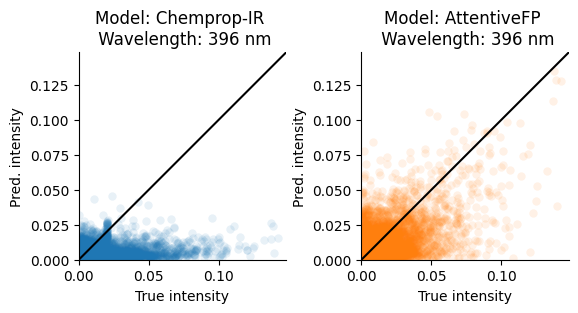

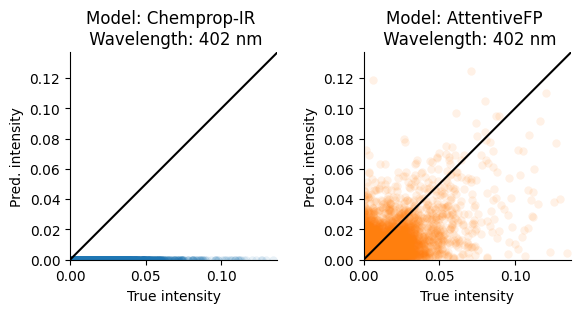

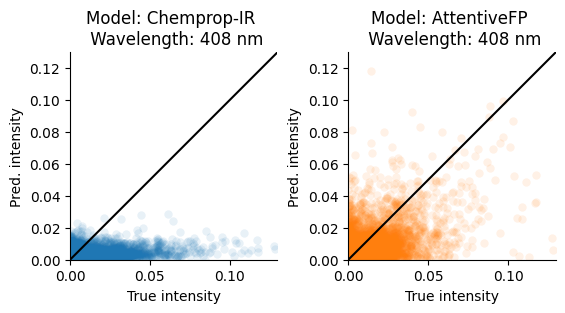

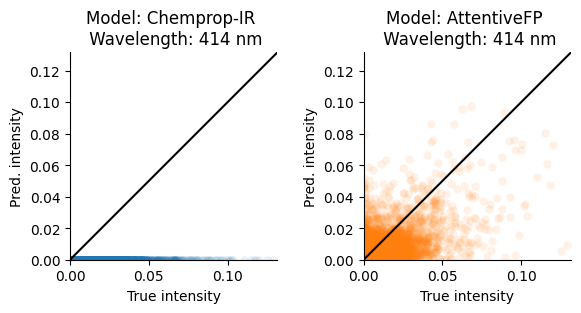

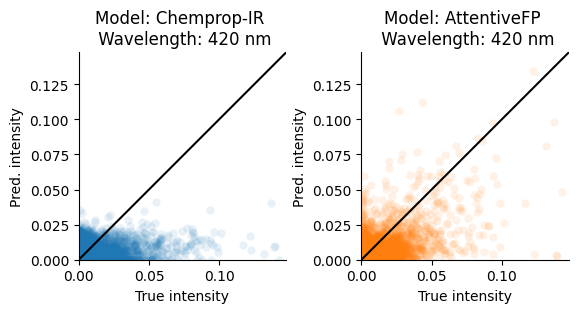

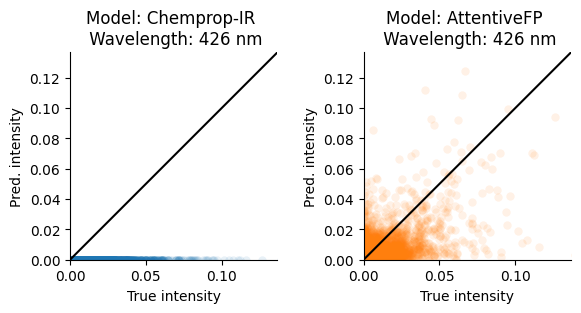

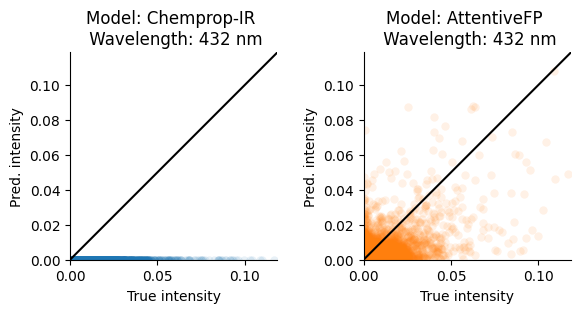

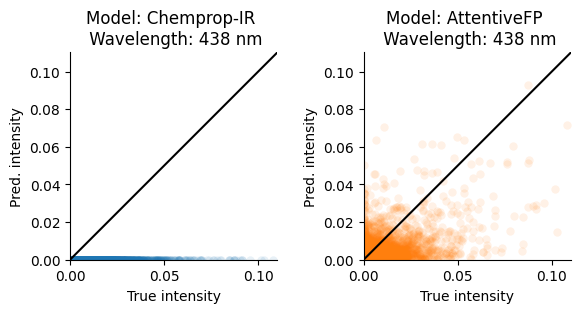

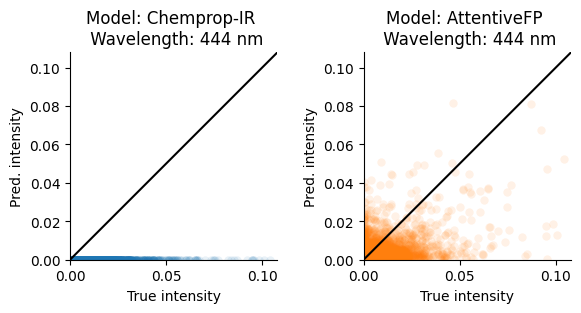

In [37]:
# Get unique wavelengths
unique_wavelengths = df_new['wavelength'].unique()
# Sort wavelength
unique_wavelengths = sorted(unique_wavelengths)

# Create a separate plot for each wavelength
for unique_wavelength in unique_wavelengths:
    # Filter the dataframe for the current wavelength
    df_filtered = df_new[df_new['wavelength'] == unique_wavelength]
    
    # Create the plot
    g = sns.FacetGrid(df_filtered, col="model", sharex= False, sharey=False, hue="model")
    g.map(sns.scatterplot, "spectra_true", "spectra_pred", alpha=.1, linewidth=0)
    #g.add_legend()
    for ax in g.axes.flat:
        ax.axline((0, 0), slope=1, color='black')
        # Get current title text
        title_text = ax.get_title()
        model = 'AttentiveFP' if 'AttentiveFP' in title_text else 'Chemprop-IR'
        ax.set_title(f'Model: {model} \n Wavelength: {unique_wavelength} nm')
        # Set axis limits to min to max of centered_divided_true and centered_divided_pred for each wavelength
        x_min = df_filtered['spectra_pred'].min()
        x_max = df_filtered['spectra_pred'].max()*1.1
        y_min = df_filtered['spectra_pred'].min()
        y_max = df_filtered['spectra_pred'].max()*1.1
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('True intensity')
        ax.set_ylabel('Pred. intensity')
    plt.savefig(f'nm_{unique_wavelength}_scatter_{chemprop_dim}.png', bbox_inches='tight')
    


In [38]:
display(df_new.head(10))

smiles  wavelength  \
2485517  Cc1nn(-c2ccc(F)cc2)c(N)c1C=NNc1nc(=O)c2cnn(-c3...         216   
2469447  Cc1ccc(CCC(=O)Nc2ccc(NC(=O)ON=Cc3cccc(-n4cccn4...         216   
2446219  COc1ccc(CN2C=C(c3nc(-c4ccnc5nccc-5c4)no3)CC2)cc1F         216   
2490315  Cn1cc(C=C2CCCc3c2nc2ccccc2c3C(=O)Nc2ccc(NS(=O)...         216   
2314611  C=C(Nc1ccc(F)c(NC(=S)NC)c1)c1cnc2c(c1)c(C(F)(F...         216   
2323149  CC(=NNc1ncccc1C(=O)Nc1cnn(-c2ccccc2)c1C)c1cn2c...         216   
2415193  CN=C1N(C)C(=O)N1c1cccc(NC(=O)c2nnn(-c3ccc4nccc...         216   
2460613  Cc1cc(-n2nccn2)ccc1NC(=O)c1ccc(C(=O)Nc2ccc(-n3...         216   
2514235  O=C1N=CNc2ccc(C(=O)Nc3cn(-c4ccco4)nc3-c3ccccc3...         216   
2444479  COc1ccc(C(=O)NN=Cc2cn(-c3ccccc3F)nc2-c2ccc(C)c...         216   

         spectra_pred  spectra_true     abs_error     model  mean_true  \
2485517  9.187924e-15  1.386922e-09  1.386912e-09  Chemprop   0.049519   
2469447  8.996774e-15  1.405748e-09  1.405739e-09  Chemprop   0.049519   
2446219  1.016666e-14  1.407812e-09  1.407802e-09  Chemprop   0.049519   
2490315  1.694773e-14  1.412374e-09  1.412357e-09  Chemprop   0.049519   
2314611  8.175439e-15  1.441569e-09  1.441561e-09  Chemprop   0.049519   
2323149  1.619615e-14  1.454266e-09  1.454250e-09  Chemprop   0.049519   
2415193  1.273528e-14  1.500017e-09  1.500005e-09  Chemprop   0.049519   
2460613  1.199560e-14  1.500890e-09  1.500878e-09  Chemprop   0.049519   
2514235  1.172101e-14  1.556049e-09  1.556038e-09  Chemprop   0.049519   
2444479  1.289044e-14  1.574530e-09  1.574517e-09  Chemprop   0.049519   

         std_true  centered_divided_pred  centered_divided_true  
2485517  0.040072              -1.235736              -1.235736  
2469447  0.040072              -1.235736              -1.235736  
2446219  0.040072              -1.235736              -1.235736  
2490315  0.040072              -1.235736              -1.235736  
2314611  0.040072              -1.235736              -1.235736  
2323149  0.040072              -1.235736              -1.235736  
2415193  0.040072              -1.235736              -1.235736  
2460613  0.040072              -1.235736              -1.235736  
2514235  0.040072              -1.235736              -1.235736  
2444479  0.040072              -1.235736              -1.235736

In [39]:
# pickle df_new
df_new.to_pickle('df_new.pkl')